In [22]:
import os
import shutil
import pandas as pd
import numpy as np
import requests
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
import shap
import matplotlib.pyplot as plt  # For visualizations
import seaborn as sns

supress_warnings = True


# Set seed for reproducibility
np.random.seed(42)

# Data Loading and Preparation

In [4]:

import pandas as pd
import numpy as np
import requests
from io import BytesIO
import zipfile
import os

def download_csv(url, filename):
    print(f"Downloading {filename} ...")
    r = requests.get(url)
    r.raise_for_status()
    with open(filename, "wb") as f:
        f.write(r.content)
    print(f"Saved to {filename}")


places_url = "https://data.cdc.gov/api/views/cwsq-ngmh/rows.csv?accessType=DOWNLOAD"
places_filepath = "/Users/sankates/workspace/MSAI/AI-391MCSML/PLACES_County.csv"

# Add check for file existence
if not os.path.exists(places_filepath):
    download_csv(places_url, places_filepath)
else:
    print(f"File already exists at {places_filepath}. Skipping download.")

places = pd.read_csv(places_filepath, dtype={'LocationID':'str'})
places = places.rename(columns={'LocationID': 'fips'})


File already exists at /Users/sankates/workspace/MSAI/AI-391MCSML/PLACES_County.csv. Skipping download.


In [ ]:
# Drop unnecessary columns
places = places.drop(columns=['Year', 'DataSource', 'StateDesc', 'Data_Value_Footnote_Symbol', 'Data_Value_Footnote'])

# Display the first few rows of the dataframe
places.head()

,StateAbbr,CountyName,CountyFIPS,LocationName,Category,Measure,Data_Value_Unit,Data_Value_Type,Data_Value,Low_Confidence_Limit,High_Confidence_Limit,TotalPopulation,TotalPop18plus,Geolocation,fips,CategoryID,MeasureId,DataValueTypeID,Short_Question_Text
0,FL,Miami-Dade,12086,12086010025,Health Outcomes,Stroke among adults,%,Crude prevalence,5.6,5.1,6.1,3992,3091,POINT (-80.254741 25.9664383),12086010025,HLTHOUT,STROKE,CrdPrv,Stroke
1,FL,Miami-Dade,12086,12086002709,Disability,Vision disability among adults,%,Crude prevalence,3.1,2.8,3.4,5273,4706,POINT (-80.1860897 25.793705),12086002709,DISABLT,VISION,CrdPrv,Vision Disability
2,FL,Miami-Dade,12086,12086007807,Disability,Vision disability among adults,%,Crude prevalence,4.4,4.0,4.8,4438,3489,POINT (-80.3102933 25.6755601),12086007807,DISABLT,VISION,CrdPrv,Vision Disability
3,FL,Miami-Dade,12086,12086001206,Health Status,Frequent physical distress among adults,%,Crude prevalence,10.0,8.9,11.2,4835,4065,POINT (-80.1708553 25.864528),12086001206,HLTHSTAT,PHLTH,CrdPrv,Frequent Physical Distress
4,FL,Miami-Dade,12086,12086010018,Disability,Any disability among adults,%,Crude prevalence,40.9,37.3,44.6,3577,2978,POINT (-80.2873705 25.92881),12086010018,DISABLT,DISABILITY,CrdPrv,Any Disability


In [12]:
places.info()

places.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3183048 entries, 0 to 3183047
Data columns (total 19 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   StateAbbr              object 
 1   CountyName             object 
 2   CountyFIPS             object 
 3   LocationName           int64  
 4   Category               object 
 5   Measure                object 
 6   Data_Value_Unit        object 
 7   Data_Value_Type        object 
 8   Data_Value             float64
 9   Low_Confidence_Limit   float64
 10  High_Confidence_Limit  float64
 11  TotalPopulation        int64  
 12  TotalPop18plus         int64  
 13  Geolocation            object 
 14  fips                   object 
 15  CategoryID             object 
 16  MeasureId              object 
 17  DataValueTypeID        object 
 18  Short_Question_Text    object 
dtypes: float64(3), int64(3), object(13)
memory usage: 461.4+ MB


,count,mean,std,min,25%,50%,75%,max
LocationName,3183048.0,2.781862e+10,1.601556e+10,1.001020e+09,1.211500e+10,2.712304e+10,4.106703e+10,5.604595e+10
Data_Value,3183048.0,2.569415e+01,2.296357e+01,2.000000e-01,9.100000e+00,1.700000e+01,3.380000e+01,9.800000e+01
Low_Confidence_Limit,3183048.0,2.346279e+01,2.192081e+01,2.000000e-01,8.000000e+00,1.500000e+01,2.990000e+01,9.760000e+01
High_Confidence_Limit,3183048.0,2.797654e+01,2.394928e+01,3.000000e-01,1.020000e+01,1.920000e+01,3.770000e+01,9.830000e+01
TotalPopulation,3183048.0,3.972090e+03,1.673262e+03,5.400000e+01,2.774000e+03,3.787000e+03,4.950000e+03,3.789200e+04
TotalPop18plus,3183048.0,3.094050e+03,1.273252e+03,5.000000e+01,2.185000e+03,2.958000e+03,3.845000e+03,3.128000e+04


In [14]:
# Ensure 'CountyFIPS' is treated as a string
places['CountyFIPS'] = places['CountyFIPS'].astype(str)

In [15]:
# Pivot the DataFrame to have separate columns for DIABETES and STROKE

places_filtered = places[
    places['MeasureId'].isin(["DIABETES", "STROKE"])
][['fips', 'CountyFIPS', 'Measure', 'Data_Value']]
places_pivot = places_filtered.pivot(index=['fips', 'CountyFIPS'], columns='Measure', values='Data_Value')
places_pivot = places_pivot.reset_index().rename_axis(None, axis=1)

places_pivot.head()

,fips,CountyFIPS,Diagnosed diabetes among adults,Stroke among adults
0,01001020100,1001,13.8,4.2
1,01001020200,1001,14.7,4.0
2,01001020300,1001,14.1,4.2
3,01001020400,1001,13.4,4.2
4,01001020501,1001,11.4,3.2


In [17]:
# Calculate total Data_Value by CountyFIPS and Measure
total_data_value_by_county_measure = places_filtered.groupby(['CountyFIPS', 'Measure'])['Data_Value'].sum().reset_index()
print(total_data_value_by_county_measure.head(10))

  CountyFIPS                          Measure  Data_Value
0      10001  Diagnosed diabetes among adults       537.3
1      10001              Stroke among adults       168.0
2      10003  Diagnosed diabetes among adults      1878.0
3      10003              Stroke among adults       512.3
4      10005  Diagnosed diabetes among adults       996.6
5      10005              Stroke among adults       323.6
6       1001  Diagnosed diabetes among adults       227.4
7       1001              Stroke among adults        66.5
8       1003  Diagnosed diabetes among adults       589.0
9       1003              Stroke among adults       172.1


In [18]:
# Create dataset for 'Diagnosed diabetes among adults'
diabetes_data = total_data_value_by_county_measure[
    total_data_value_by_county_measure['Measure'] == "Diagnosed diabetes among adults"
].copy()

# Create dataset for 'Stroke among adults'
stroke_data = total_data_value_by_county_measure[
    total_data_value_by_county_measure['Measure'] == "Stroke among adults"
].copy()

# Prepare places dataset for merging (select relevant columns and drop duplicates for CountyFIPS)
county_info = places[['CountyFIPS', 'StateAbbr', 'CountyName']].drop_duplicates(subset=['CountyFIPS']).copy()

# Merge diabetes_data with county_info
diabetes_data = pd.merge(diabetes_data, county_info, on='CountyFIPS', how='left')

# Merge stroke_data with county_info
stroke_data = pd.merge(stroke_data, county_info, on='CountyFIPS', how='left')

print("Diabetes Data Head:")
print(diabetes_data.head())
print("\nStroke Data Head:")
print(stroke_data.head())

Diabetes Data Head:
  CountyFIPS                          Measure  Data_Value StateAbbr  \
0      10001  Diagnosed diabetes among adults       537.3        DE   
1      10003  Diagnosed diabetes among adults      1878.0        DE   
2      10005  Diagnosed diabetes among adults       996.6        DE   
3       1001  Diagnosed diabetes among adults       227.4        AL   
4       1003  Diagnosed diabetes among adults       589.0        AL   

   CountyName  
0        Kent  
1  New Castle  
2      Sussex  
3     Autauga  
4     Baldwin  

Stroke Data Head:
  CountyFIPS              Measure  Data_Value StateAbbr  CountyName
0      10001  Stroke among adults       168.0        DE        Kent
1      10003  Stroke among adults       512.3        DE  New Castle
2      10005  Stroke among adults       323.6        DE      Sussex
3       1001  Stroke among adults        66.5        AL     Autauga
4       1003  Stroke among adults       172.1        AL     Baldwin


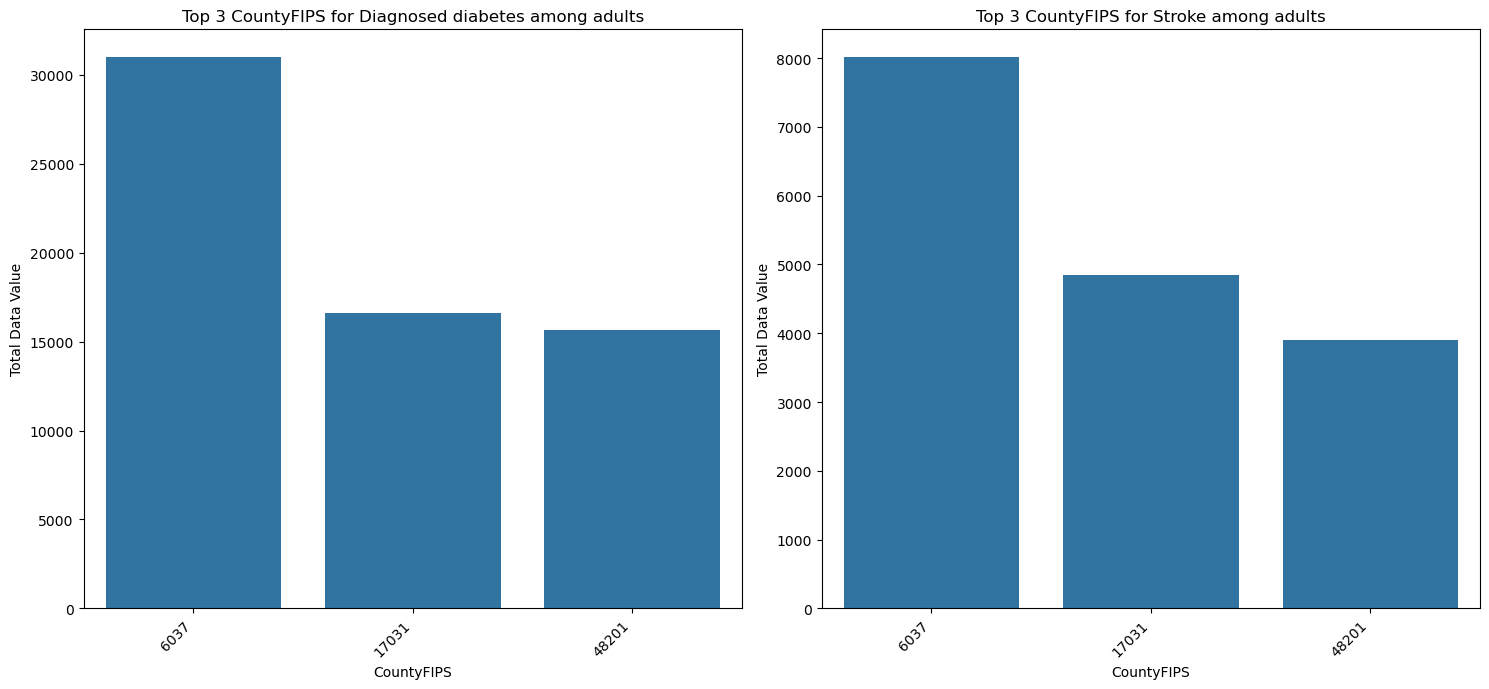

In [20]:
# Get unique measures
unique_measures = total_data_value_by_county_measure['Measure'].unique()

plt.figure(figsize=(15, 7))

for i, measure in enumerate(unique_measures):
    # Filter data for the current measure
    measure_data = total_data_value_by_county_measure[
        total_data_value_by_county_measure['Measure'] == measure
    ]

    # Get top 3 CountyFIPS for the current measure
    top_3_counties = measure_data.nlargest(3, 'Data_Value')

    # Create a subplot for each measure
    plt.subplot(1, len(unique_measures), i + 1)
    sns.barplot(x='CountyFIPS', y='Data_Value', data=top_3_counties)
    plt.title(f'Top 3 CountyFIPS for {measure}')
    plt.xlabel('CountyFIPS')
    plt.ylabel('Total Data Value')
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

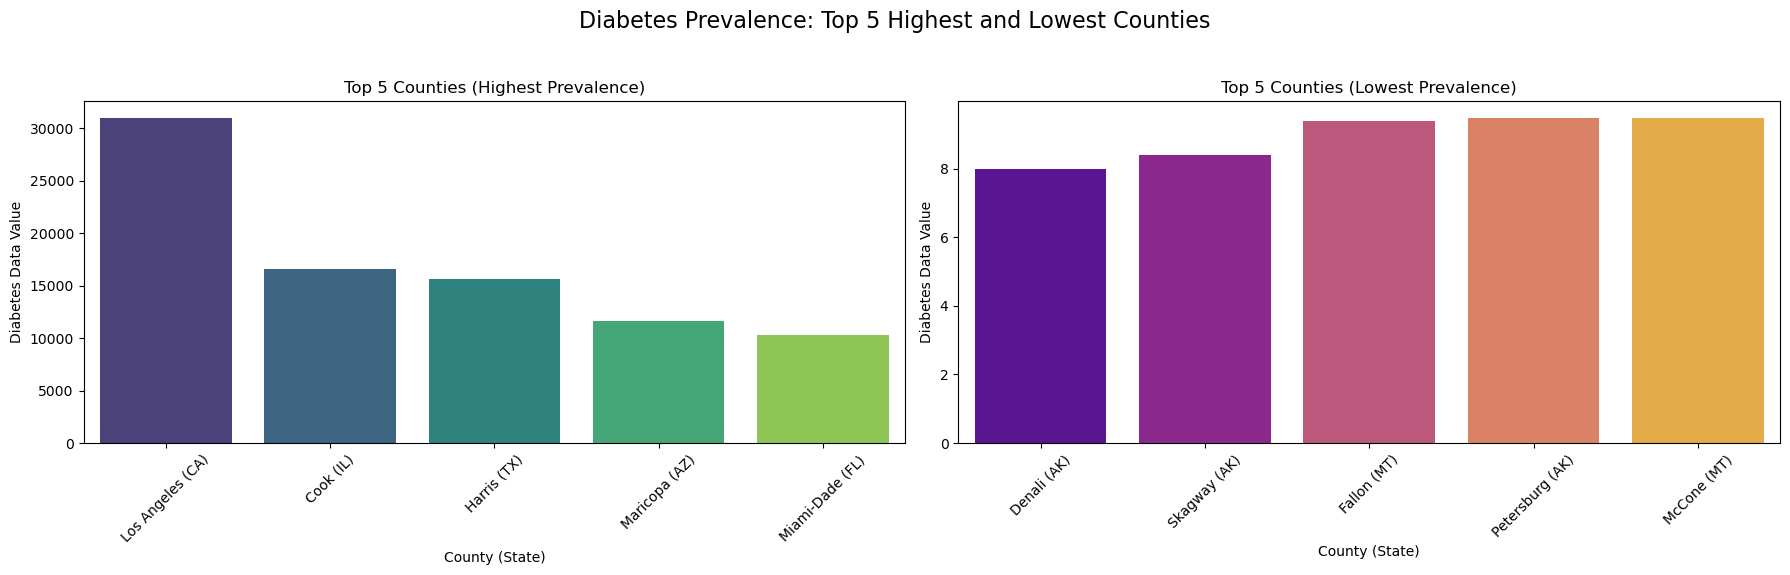

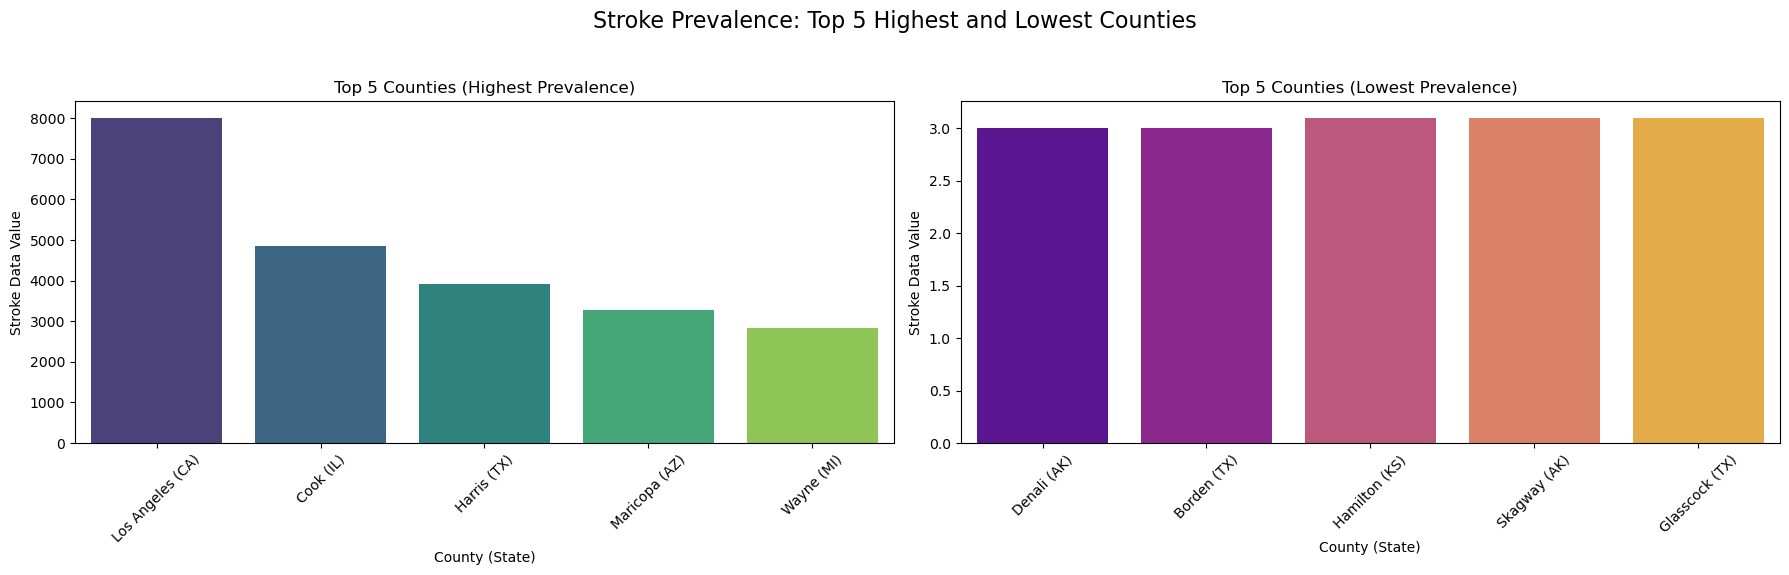

In [26]:
# Function to plot top 5 highest and lowest counties for a given measure

def plot_top_and_bottom_counties(df, measure_name, value_col='Data_Value'):
    # Sort for top 5 highest
    top_5_highest = df.nlargest(5, value_col)
    # Sort for top 5 lowest
    top_5_lowest = df.nsmallest(5, value_col)

    # Create combined label for x-axis
    top_5_highest['County_State'] = top_5_highest['CountyName'] + ' (' + top_5_highest['StateAbbr'] + ')'
    top_5_lowest['County_State'] = top_5_lowest['CountyName'] + ' (' + top_5_lowest['StateAbbr'] + ')'

    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle(f'{measure_name} Prevalence: Top 5 Highest and Lowest Counties', fontsize=16)

    # Plot top 5 highest
    sns.barplot(
        ax=axes[0], 
        x='County_State', 
        y=value_col, 
        data=top_5_highest, 
        hue='County_State',  # Assign x to hue
        palette='viridis',
        legend=False  # Disable the legend for the same effect
    )
    axes[0].set_title('Top 5 Counties (Highest Prevalence)')
    axes[0].set_xlabel('County (State)')
    axes[0].set_ylabel(f'{measure_name} Data Value')
    axes[0].tick_params(axis='x', rotation=45)

    # Plot top 5 lowest
    sns.barplot(
        ax=axes[1], 
        x='County_State', 
        y=value_col, 
        data=top_5_lowest, 
        hue='County_State',  # Assign x to hue
        palette='plasma',
        legend=False  # Disable the legend for the same effect
    )
    axes[1].set_title('Top 5 Counties (Lowest Prevalence)')
    axes[1].set_xlabel('County (State)')
    axes[1].set_ylabel(f'{measure_name} Data Value')
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Plot for Diabetes Data
plot_top_and_bottom_counties(diabetes_data, 'Diabetes')

# Plot for Stroke Data
plot_top_and_bottom_counties(stroke_data, 'Stroke')


In [27]:
acs_vars = [
    "NAME", "B19013_001E", "B17001_002E", "B23025_005E",
    "B15003_022E", "B15003_023E", "B15003_024E", "B15003_025E",
    "B27001_017E"
]
acs_var_string = ",".join(acs_vars)
print(acs_var_string)
# acs_url = f"https://api.census.gov/data/2022/acs/acs5?get=NAME,B19013_001E,B17001_002E,B23025_005E,B15003_022E,B15003_023E,B15003_024E,B15003_025E,B27001_017E&for=county:*&key=0ad5287f1284d961ec12a7a3938b48a56fa26ee1"
# download_csv(acs_url, "/Users/sankates/workspace/MSAI/AI-391MCSMLACS_raw.json")


NAME,B19013_001E,B17001_002E,B23025_005E,B15003_022E,B15003_023E,B15003_024E,B15003_025E,B27001_017E


In [29]:
# Load ACS data
acs = pd.read_json("/Users/sankates/workspace/MSAI/AI-391MCSML/ACS_raw.json")
acs.columns = acs.iloc[0]
acs = acs[1:]

acs['fips'] = acs['state'] + acs['county']

# Rename columns for clarity
acs = acs.rename(columns={
    "B19013_001E": "median_income",
    "B17001_002E": "poverty_count",
    "B23025_005E": "unemployed_count",
    "B27001_017E": "uninsured_count"
})

acs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3222 entries, 1 to 3222
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   NAME              3222 non-null   object
 1   median_income     3222 non-null   object
 2   poverty_count     3222 non-null   object
 3   unemployed_count  3222 non-null   object
 4   B15003_022E       3222 non-null   object
 5   B15003_023E       3222 non-null   object
 6   B15003_024E       3222 non-null   object
 7   B15003_025E       3222 non-null   object
 8   uninsured_count   3222 non-null   object
 9   state             3222 non-null   object
 10  county            3222 non-null   object
 11  fips              3222 non-null   object
dtypes: object(12)
memory usage: 302.2+ KB


In [30]:
acs.head()


,NAME,median_income,poverty_count,unemployed_count,B15003_022E,B15003_023E,B15003_024E,B15003_025E,uninsured_count,state,county,fips
1,"Autauga County, Alabama",68315,6630,752,6726,4014,702,437,533,01,001,01001
2,"Baldwin County, Alabama",71039,23445,3825,33474,15077,3483,2351,2295,01,003,01003
3,"Barbour County, Alabama",39712,5280,516,1167,640,188,105,219,01,005,01005
4,"Bibb County, Alabama",50669,4297,786,1047,507,109,76,234,01,007,01007
5,"Blount County, Alabama",57440,8277,1578,3840,1751,270,156,720,01,009,01009


In [31]:

# ejs_url = "https://gaftp.epa.gov/EJSCREEN/2023/EJSCREEN_2023_USPR_Public.zip"
# download_csv(ejs_url, "/Users/sankates/workspace/MSAI/AI-391MCSMLEJSCREEN.zip")

# with zipfile.ZipFile("EJSCREEN.zip", "r") as z:
#     z.extractall("ejscreen")

bg = pd.read_csv("/Users/sankates/workspace/MSAI/AI-391MCSML/EJSCREEN_2024_BG_StatePct_with_AS_CNMI_GU_VI.csv")

base_cols = ['ID','STATE_NAME','ST_ABBREV','CNTY_NAME','ACSTOTPOP']
missing_base = [c for c in base_cols if c not in bg.columns]
print(missing_base)

print(bg.info())
bg.head(5)

/var/folders/xv/jppz3tnj7z10dvcn0jp_xfk00000gp/T/ipykernel_60556/3087392326.py:7: DtypeWarning: Columns (181,182,183,194,195,196,197,198,219,220) have mixed types. Specify dtype option on import or set low_memory=False.
  bg = pd.read_csv("/Users/sankates/workspace/MSAI/AI-391MCSML/EJSCREEN_2024_BG_StatePct_with_AS_CNMI_GU_VI.csv")


[]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243022 entries, 0 to 243021
Columns: 229 entries, ID to Shape_Area
dtypes: float64(173), int64(3), object(53)
memory usage: 424.6+ MB
None


,ID,STATE_NAME,ST_ABBREV,CNTY_NAME,REGION,ACSTOTPOP,ACSIPOVBAS,ACSEDUCBAS,ACSTOTHH,ACSTOTHU,...,T_D2_DWATER,T_D5_DWATER,AREALAND,AREAWATER,NPL_CNT,TSDF_CNT,EXCEED_COUNT_80,EXCEED_COUNT_80_SUP,Shape_Length,Shape_Area
0,10010201001,Alabama,AL,Autauga County,4,558.0,558.0,423.0,261.0,279.0,...,86 %ile,95 %ile,4264299.0,28435.0,0.0,0.0,1,1.0,0.110793,0.000412
1,10010201002,Alabama,AL,Autauga County,4,1307.0,1307.0,843.0,439.0,454.0,...,76 %ile,91 %ile,5561004.0,0.0,0.0,0.0,0,1.0,0.096868,0.000534
2,10010202001,Alabama,AL,Autauga County,4,548.0,540.0,428.0,204.0,276.0,...,92 %ile,85 %ile,2058374.0,0.0,0.0,0.0,1,1.0,0.062129,0.000197
3,10010202002,Alabama,AL,Autauga County,4,1313.0,1129.0,1047.0,340.0,404.0,...,88 %ile,85 %ile,1262444.0,5669.0,0.0,0.0,1,1.0,0.052097,0.000122
4,10010203001,Alabama,AL,Autauga County,4,2835.0,2829.0,1863.0,1011.0,1115.0,...,79 %ile,80 %ile,3866513.0,9054.0,0.0,0.0,0,1.0,0.089441,0.000372


In [33]:
# Pick candidate feature columns
candidate_features = [
    'PM25','OZONE','DSLPM','RSEI_AIR','PTRAF',
    'PNPL','PRMP','PWDIS','DWATER','NO2',
    'DEMOGIDX_2','DEMOGIDX_5',
    'PEOPCOLORPCT','LOWINCPCT','UNEMPPCT','LINGISOPCT','LESSHSPCT','UNDER5PCT','OVER64PCT'
]

feature_cols = [c for c in candidate_features if c in bg.columns]
print("Using feature columns:", feature_cols)

Using feature columns: ['PM25', 'OZONE', 'DSLPM', 'RSEI_AIR', 'PTRAF', 'PNPL', 'PRMP', 'PWDIS', 'DWATER', 'NO2', 'DEMOGIDX_2', 'DEMOGIDX_5', 'PEOPCOLORPCT', 'LOWINCPCT', 'UNEMPPCT', 'LINGISOPCT', 'LESSHSPCT', 'UNDER5PCT', 'OVER64PCT']


In [36]:
# Aggregate block group data to county level

output_path = "/Users/sankates/workspace/MSAI/AI-391MCSML/EJSCREEN_county_from_BG.csv"

# Check if the file already exists
if os.path.exists(output_path):
    county_ejs = pd.read_csv(output_path)
    print(county_ejs.info())
    print(f"Loaded county_ejs from existing file: {output_path}")
else:
    # Ensure numeric
    for col in feature_cols + ['ACSTOTPOP']:
        bg[col] = pd.to_numeric(bg[col], errors='coerce')

    # Drop rows without population
    bg = bg[bg['ACSTOTPOP'] > 0].copy()

    group_cols = ['ST_ABBREV','STATE_NAME','CNTY_NAME']

    def weighted_mean(series, weights):
        mask = series.notna() & weights.notna() & (weights > 0)
        if not mask.any():
            return np.nan
        return np.average(series[mask], weights=weights[mask])

    grouped = bg.groupby(group_cols, as_index=False)

    records = []
    for keys, group in grouped:
        rec = {}
        # keys is tuple matching group_cols
        for k, name in zip(keys, group_cols):
            rec[name] = k
        rec['total_pop'] = group['ACSTOTPOP'].sum()
        for col in feature_cols:
            rec[col] = weighted_mean(group[col], group['ACSTOTPOP'])
        records.append(rec)

    county_ejs = pd.DataFrame(records)
    county_ejs.to_csv(output_path, index=False)
    print(f"Generated and saved county_ejs to: {output_path}")

county_ejs.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3233 entries, 0 to 3232
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ST_ABBREV     3233 non-null   object 
 1   STATE_NAME    3233 non-null   object 
 2   CNTY_NAME     3233 non-null   object 
 3   total_pop     3233 non-null   float64
 4   PM25          3109 non-null   float64
 5   OZONE         3109 non-null   float64
 6   DSLPM         3192 non-null   float64
 7   RSEI_AIR      3233 non-null   float64
 8   PTRAF         3222 non-null   float64
 9   PNPL          3230 non-null   float64
 10  PRMP          3230 non-null   float64
 11  PWDIS         3192 non-null   float64
 12  DWATER        3142 non-null   float64
 13  NO2           3222 non-null   float64
 14  DEMOGIDX_2    3233 non-null   float64
 15  DEMOGIDX_5    3222 non-null   float64
 16  PEOPCOLORPCT  3233 non-null   float64
 17  LOWINCPCT     3233 non-null   float64
 18  UNEMPPCT      3233 non-null 

,ST_ABBREV,STATE_NAME,CNTY_NAME,total_pop,PM25,OZONE,DSLPM,RSEI_AIR,PTRAF,PNPL,...,NO2,DEMOGIDX_2,DEMOGIDX_5,PEOPCOLORPCT,LOWINCPCT,UNEMPPCT,LINGISOPCT,LESSHSPCT,UNDER5PCT,OVER64PCT
0,AK,Alaska,Aleutians East Borough,3407.0,NaN,NaN,NaN,18.795745,0.000000e+00,0.000000,...,0.104081,2.746792,1.403138,0.842677,0.333420,0.044888,0.038709,0.189420,0.031699,0.116231
1,AK,Alaska,Aleutians West Census Area,5219.0,NaN,NaN,NaN,3.631383,0.000000e+00,0.323449,...,0.612247,2.279281,1.412247,0.765856,0.232047,0.029511,0.047556,0.102912,0.042154,0.063039
2,AK,Alaska,Anchorage Municipality,290674.0,NaN,NaN,NaN,47.484369,1.186345e+06,1.337817,...,7.358643,1.601151,1.373721,0.447580,0.223587,0.052457,0.029756,0.060674,0.066858,0.119612
3,AK,Alaska,Bethel Census Area,18538.0,NaN,NaN,NaN,24.384799,0.000000e+00,0.000000,...,0.104083,3.429026,1.932134,0.911965,0.510039,0.173817,0.027528,0.175679,0.106268,0.077409
4,AK,Alaska,Bristol Bay Borough,854.0,NaN,NaN,NaN,22.729112,0.000000e+00,0.000000,...,0.895863,1.717261,1.290505,0.556206,0.188769,0.027460,0.007042,0.050314,0.077283,0.126464


In [38]:
# Load FIPS lookup data

fips_lookup = pd.read_excel('/Users/sankates/workspace/MSAI/AI-391MCSML/merged-geocodes.xlsx')
print(fips_lookup.head())

# Rename columns in fips_lookup for easier merging
# Corrected column names based on available fips_lookup (from kernel state)
fips_lookup = fips_lookup.rename(columns={'Name': 'STATE_NAME', 'fips': 'fips_from_lookup', 'Area Name' : 'CNTY_NAME'})

# Create the new dataset by merging county_ejs with fips_lookup
county_ejs_with_fips = pd.merge(
    county_ejs,
    fips_lookup[['STATE_NAME', 'CNTY_NAME', 'fips_from_lookup']],
    on=['STATE_NAME', 'CNTY_NAME'],
    how='left'
)

# Rename the merged fips column to 'fips'
county_ejs_with_fips = county_ejs_with_fips.rename(columns={'fips_from_lookup': 'fips'})

county_ejs_with_fips.tail(10)

   State FIPS Code  County FIPS Code       Area Name     Name  fips
0                1                 1  Autauga County  Alabama  1001
1                1                 3  Baldwin County  Alabama  1003
2                1                 5  Barbour County  Alabama  1005
3                1                 7     Bibb County  Alabama  1007
4                1                 9   Blount County  Alabama  1009


,ST_ABBREV,STATE_NAME,CNTY_NAME,total_pop,PM25,OZONE,DSLPM,RSEI_AIR,PTRAF,PNPL,...,DEMOGIDX_2,DEMOGIDX_5,PEOPCOLORPCT,LOWINCPCT,UNEMPPCT,LINGISOPCT,LESSHSPCT,UNDER5PCT,OVER64PCT,fips
3223,WY,Wyoming,Niobrara County,2460.0,4.460460,64.361420,0.024485,0.026305,24445.235105,0.0,...,1.771804,1.974907,0.106504,0.428117,0.050864,0.000000,0.081010,0.034553,0.241057,56027.0
3224,WY,Wyoming,Park County,29878.0,4.630895,60.448647,0.040798,0.003447,77637.167580,0.0,...,1.336383,1.271734,0.116976,0.281994,0.025544,0.004568,0.044978,0.048631,0.240679,56029.0
3225,WY,Wyoming,Platte County,8618.0,4.454283,65.295025,0.049574,1288.350669,32386.765802,0.0,...,1.487504,1.859575,0.146902,0.295239,0.036410,0.014560,0.066163,0.044210,0.266303,56031.0
3226,WY,Wyoming,Sheridan County,31176.0,5.131052,58.859135,0.080238,0.000634,158391.482743,0.0,...,1.066384,1.289544,0.094335,0.223912,0.028945,0.007197,0.035683,0.046478,0.216769,56033.0
3227,WY,Wyoming,Sublette County,8801.0,3.551251,63.564417,0.009656,0.000000,10785.772464,0.0,...,0.907291,1.130530,0.094307,0.174825,0.039902,0.000000,0.041069,0.051131,0.222588,56035.0
3228,WY,Wyoming,Sweetwater County,42079.0,4.282689,63.228821,0.155386,108.897190,260872.886866,0.0,...,1.566949,1.709557,0.221678,0.236282,0.058473,0.021776,0.069937,0.059008,0.135507,56037.0
3229,WY,Wyoming,Teton County,23346.0,4.445018,61.689650,0.031110,0.000000,112293.783220,0.0,...,1.322742,1.069412,0.203375,0.181320,0.019313,0.045032,0.042555,0.041206,0.166495,56039.0
3230,WY,Wyoming,Uinta County,20546.0,5.523874,66.295652,0.094082,11.991527,150094.777935,0.0,...,1.298593,1.725231,0.132386,0.253122,0.032370,0.006226,0.056406,0.065171,0.155894,56041.0
3231,WY,Wyoming,Washakie County,7725.0,4.568317,60.398357,0.030182,202.988923,68582.186463,0.0,...,1.625908,1.431929,0.184337,0.296176,0.016015,0.003802,0.054106,0.043366,0.233269,56043.0
3232,WY,Wyoming,Weston County,6870.0,4.655015,63.462557,0.034732,79.128647,32764.091428,0.0,...,1.411802,1.601040,0.144978,0.274015,0.042133,0.000000,0.083818,0.039447,0.208151,56045.0


In [40]:
# Convert 'fips' column to int64, handling NaN values
# Fill NaN values with 0 before converting to int, as int type cannot hold NaN
county_ejs_with_fips['fips'] = county_ejs_with_fips['fips'].fillna(0).astype('int64')

output_csv_path = "/Users/sankates/workspace/MSAI/AI-391MCSML/county_ejs_with_fips.csv"
county_ejs_with_fips.to_csv(output_csv_path, index=False)

print(f"DataFrame saved to {output_csv_path}")
print("Info of saved DataFrame with converted fips column:")
county_ejs_with_fips.info()
county_ejs_with_fips.head()

DataFrame saved to /Users/sankates/workspace/MSAI/AI-391MCSML/county_ejs_with_fips.csv
Info of saved DataFrame with converted fips column:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3233 entries, 0 to 3232
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ST_ABBREV     3233 non-null   object 
 1   STATE_NAME    3233 non-null   object 
 2   CNTY_NAME     3233 non-null   object 
 3   total_pop     3233 non-null   float64
 4   PM25          3109 non-null   float64
 5   OZONE         3109 non-null   float64
 6   DSLPM         3192 non-null   float64
 7   RSEI_AIR      3233 non-null   float64
 8   PTRAF         3222 non-null   float64
 9   PNPL          3230 non-null   float64
 10  PRMP          3230 non-null   float64
 11  PWDIS         3192 non-null   float64
 12  DWATER        3142 non-null   float64
 13  NO2           3222 non-null   float64
 14  DEMOGIDX_2    3233 non-null   float64
 15  DEMOGIDX_5    3222

,ST_ABBREV,STATE_NAME,CNTY_NAME,total_pop,PM25,OZONE,DSLPM,RSEI_AIR,PTRAF,PNPL,...,DEMOGIDX_2,DEMOGIDX_5,PEOPCOLORPCT,LOWINCPCT,UNEMPPCT,LINGISOPCT,LESSHSPCT,UNDER5PCT,OVER64PCT,fips
0,AK,Alaska,Aleutians East Borough,3407.0,NaN,NaN,NaN,18.795745,0.000000e+00,0.000000,...,2.746792,1.403138,0.842677,0.333420,0.044888,0.038709,0.189420,0.031699,0.116231,2013
1,AK,Alaska,Aleutians West Census Area,5219.0,NaN,NaN,NaN,3.631383,0.000000e+00,0.323449,...,2.279281,1.412247,0.765856,0.232047,0.029511,0.047556,0.102912,0.042154,0.063039,2016
2,AK,Alaska,Anchorage Municipality,290674.0,NaN,NaN,NaN,47.484369,1.186345e+06,1.337817,...,1.601151,1.373721,0.447580,0.223587,0.052457,0.029756,0.060674,0.066858,0.119612,2020
3,AK,Alaska,Bethel Census Area,18538.0,NaN,NaN,NaN,24.384799,0.000000e+00,0.000000,...,3.429026,1.932134,0.911965,0.510039,0.173817,0.027528,0.175679,0.106268,0.077409,2050
4,AK,Alaska,Bristol Bay Borough,854.0,NaN,NaN,NaN,22.729112,0.000000e+00,0.000000,...,1.717261,1.290505,0.556206,0.188769,0.027460,0.007042,0.050314,0.077283,0.126464,2060


In [46]:
# Load Food Access Research Atlas data
food = pd.read_csv("/Users/sankates/workspace/MSAI/AI-391MCSML/Food Access Research Atlas.csv", dtype={'CensusTract':'str'})
#print(food.columns)
# CensusTract,State,County,Urban,Pop2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,LILATracts_halfAnd10,LILATracts_1And20,LILATracts_Vehicle,HUNVFlag,LowIncomeTracts,PovertyRate,MedianFamilyIncome,LA1and10,LAhalfand10,LA1and20,LATracts_half,LATracts1,LATracts10,LATracts20,LATractsVehicle_20,LAPOP1_10,LAPOP05_10,LAPOP1_20,LALOWI1_10,LALOWI05_10,LALOWI1_20,lapophalf,lapophalfshare,lalowihalf,lalowihalfshare,lakidshalf,lakidshalfshare,laseniorshalf,laseniorshalfshare,lawhitehalf,lawhitehalfshare,lablackhalf,lablackhalfshare,laasianhalf,laasianhalfshare,lanhopihalf,lanhopihalfshare,laaianhalf,laaianhalfshare,laomultirhalf,laomultirhalfshare,lahisphalf,lahisphalfshare,lahunvhalf,lahunvhalfshare,lasnaphalf,lasnaphalfshare,lapop1,lapop1share,lalowi1,lalowi1share,lakids1,lakids1share,laseniors1,laseniors1share,lawhite1,lawhite1share,lablack1,lablack1share,laasian1,laasian1share,lanhopi1,lanhopi1share,laaian1,laaian1share,laomultir1,laomultir1share,lahisp1,lahisp1share,lahunv1,lahunv1share,lasnap1,lasnap1share,lapop10,lapop10share,lalowi10,lalowi10share,lakids10,lakids10share,laseniors10,laseniors10share,lawhite10,lawhite10share,lablack10,lablack10share,laasian10,laasian10share,lanhopi10,lanhopi10share,laaian10,laaian10share,laomultir10,laomultir10share,lahisp10,lahisp10share,lahunv10,lahunv10share,lasnap10,lasnap10share,lapop20,lapop20share,lalowi20,lalowi20share,lakids20,lakids20share,laseniors20,laseniors20share,lawhite20,lawhite20share,lablack20,lablack20share,laasian20,laasian20share,lanhopi20,lanhopi20share,laaian20,laaian20share,laomultir20,laomultir20share,lahisp20,lahisp20share,lahunv20,lahunv20share,lasnap20,lasnap20share,TractLOWI,TractKids,TractSeniors,TractWhite,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP

# Create county FIPS (first 5 digits of tract GEOID)
food['fips'] = food['CensusTract'].str[:5]

# Only use tracts with recorded population
food = food[food['Pop2010'] > 0]

# Functions for weighted averages
def weighted_mean(series, weights):
    mask = series.notna() & weights.notna() & (weights > 0)
    if not mask.any():
        return np.nan
    return np.average(series[mask], weights=weights[mask])

# Aggregate to county level
food_county = (
    food.groupby('fips')
        .apply(lambda g: pd.Series({
            # Count of low-income / low-access tracts
            'low_access_tracts': g['LILATracts_1And10'].fillna(0).sum(),

            # Percent of households with low vehicle access
            'pct_low_vehicle_access': weighted_mean(g['HUNVFlag'], g['Pop2010']),

            # Poverty / SNAP weighted averages
            'poverty_rate': weighted_mean(g['PovertyRate'], g['Pop2010']),
        }), include_groups=False)
        .reset_index()
)

food_county.head()

,fips,low_access_tracts,pct_low_vehicle_access,poverty_rate
0,10001,7.0,0.526215,13.881833
1,10003,19.0,0.239005,11.927730
2,10005,6.0,0.070628,11.873381
3,10010,5.0,0.449341,15.137584
4,10030,4.0,0.223543,10.947872


In [47]:
# Ensure 'fips' is numeric
food_county['fips'] = pd.to_numeric(food_county['fips'], errors='coerce').astype(int)
print(food_county.nsmallest(5, 'fips'))

    fips  low_access_tracts  pct_low_vehicle_access  poverty_rate
0  10001                7.0                0.526215     13.881833
1  10003               19.0                0.239005     11.927730
2  10005                6.0                0.070628     11.873381
3  10010                5.0                0.449341     15.137584
4  10030                4.0                0.223543     10.947872


In [48]:
# Load ERS County Typology data
df = pd.read_csv("/Users/sankates/workspace/MSAI/AI-391MCSML/erscountytypology2025edition.csv", dtype={'FIPStxt':'str'})

# Pivot Attribute → feature columns
rucc = df.pivot_table(
    index=["FIPStxt", "State", "County_Name", "Metro2023"],
    columns="Attribute",
    values="Value",
    aggfunc="first"
).reset_index()

# Clean up column names
rucc.columns.name = None
rucc = rucc.rename(columns={"FIPStxt": "fips"})


# Show result
rucc.head()

,fips,State,County_Name,Metro2023,High_Farming_2025,High_Government_2025,High_Manufacturing_2025,High_Mining_2025,High_Recreation_2025,Housing_Stress_2025,Industry_Dependence_2025,Low_Employment_2025,Low_PostSecondary_Ed_2025,Nonspecialized_2025,Persistent_Poverty_1721,Population_Loss_2025,Retirement_Destination_2025
0,01001,AL,Autauga County,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1,01003,AL,Baldwin County,1,0,0,0,0,1,0,5,0,0,0,0,0,1
2,01005,AL,Barbour County,0,0,0,1,0,0,1,3,1,1,0,1,1,0
3,01007,AL,Bibb County,1,0,0,0,0,0,0,0,1,1,1,0,0,0
4,01009,AL,Blount County,1,0,0,0,0,0,0,0,0,0,1,0,0,0


In [49]:
from functools import reduce


# --- 1. Standardize 'fips' column and select relevant columns for each DataFrame ---

# Prepare rucc
rucc_standardized = rucc.copy()
# Ensure fips is numeric and int64, handle potential non-numeric values by filling with 0
rucc_standardized['fips'] = pd.to_numeric(rucc_standardized['fips'], errors='coerce').fillna(0).astype('int64')
# Drop redundant state/county name columns as they will come from county_ejs_with_fips
rucc_standardized = rucc_standardized.drop(columns=['State', 'County_Name'], errors='ignore')

# Prepare food_county (fips is already int64 after previous steps)
food_county_standardized = food_county.copy()
food_county_standardized['fips'] = food_county_standardized['fips'].astype('int64')

# Prepare county_ejs_with_fips (fips is already int64 after previous steps)
# This will serve as our base DataFrame for merging.
county_ejs_standardized = county_ejs_with_fips.copy()
county_ejs_standardized['fips'] = county_ejs_standardized['fips'].astype('int64')

# Prepare acs
acs_standardized = acs[['fips', 'median_income', 'poverty_count', 'unemployed_count', 'uninsured_count']].copy()
acs_standardized['fips'] = pd.to_numeric(acs_standardized['fips'], errors='coerce').fillna(0).astype('int64')

# Prepare diabetes_data
diabetes_standardized = diabetes_data.copy()
diabetes_standardized = diabetes_standardized.rename(columns={'CountyFIPS': 'fips', 'Data_Value': 'diabetes_prev'})
# Ensure fips is int64, handle potential non-numeric values by filling with 0
diabetes_standardized['fips'] = pd.to_numeric(diabetes_standardized['fips'], errors='coerce').fillna(0).astype('int64')
# Select only fips and the new prevalence column
diabetes_standardized = diabetes_standardized[['fips', 'diabetes_prev']]

# Prepare stroke_data
stroke_standardized = stroke_data.copy()
stroke_standardized = stroke_standardized.rename(columns={'CountyFIPS': 'fips', 'Data_Value': 'stroke_prev'})
# Ensure fips is int64, handle potential non-numeric values by filling with 0
stroke_standardized['fips'] = pd.to_numeric(stroke_standardized['fips'], errors='coerce').fillna(0).astype('int64')
# Select only fips and the new prevalence column
stroke_standardized = stroke_standardized[['fips', 'stroke_prev']]

# --- 2. List of DataFrames to merge, starting with county_ejs_with_fips as the base ---
dfs_to_merge = [
    county_ejs_standardized, # Base dataframe
    rucc_standardized,
    food_county_standardized,
    acs_standardized,
    diabetes_standardized,
    stroke_standardized
]

# --- 3. Perform the merge ---
data = reduce(lambda left, right: pd.merge(left, right, on='fips', how='left'), dfs_to_merge)

# Display head to confirm the merge result
print("Merged Data Head:")
data.head()

Merged Data Head:


,ST_ABBREV,STATE_NAME,CNTY_NAME,total_pop,PM25,OZONE,DSLPM,RSEI_AIR,PTRAF,PNPL,...,Retirement_Destination_2025,low_access_tracts,pct_low_vehicle_access,poverty_rate,median_income,poverty_count,unemployed_count,uninsured_count,diabetes_prev,stroke_prev
0,AK,Alaska,Aleutians East Borough,3407.0,NaN,NaN,NaN,18.795745,0.000000e+00,0.000000,...,0.0,NaN,NaN,NaN,79961,429,106,173,12.1,3.5
1,AK,Alaska,Aleutians West Census Area,5219.0,NaN,NaN,NaN,3.631383,0.000000e+00,0.323449,...,0.0,NaN,NaN,NaN,100662,478,110,143,20.5,6.3
2,AK,Alaska,Anchorage Municipality,290674.0,NaN,NaN,NaN,47.484369,1.186345e+06,1.337817,...,0.0,NaN,NaN,NaN,95731,27415,7747,2354,516.2,177.7
3,AK,Alaska,Bethel Census Area,18538.0,NaN,NaN,NaN,24.384799,0.000000e+00,0.000000,...,0.0,NaN,NaN,NaN,64094,4586,1265,289,38.3,16.3
4,AK,Alaska,Bristol Bay Borough,854.0,NaN,NaN,NaN,22.729112,0.000000e+00,0.000000,...,0.0,NaN,NaN,NaN,94167,66,12,5,10.7,3.9


In [50]:
output_path = "/Users/sankates/workspace/MSAI/AI-391MCSML/data.csv"
data.to_csv(output_path, index=False)
print(f"DataFrame 'data' saved to {output_path}")

DataFrame 'data' saved to /Users/sankates/workspace/MSAI/AI-391MCSML/data.csv


In [52]:
# Display info of the final merged DataFrame
print("Merged Data Info:")
data.info()

Merged Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3233 entries, 0 to 3232
Data columns (total 47 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ST_ABBREV                    3233 non-null   object 
 1   STATE_NAME                   3233 non-null   object 
 2   CNTY_NAME                    3233 non-null   object 
 3   total_pop                    3233 non-null   float64
 4   PM25                         3109 non-null   float64
 5   OZONE                        3109 non-null   float64
 6   DSLPM                        3192 non-null   float64
 7   RSEI_AIR                     3233 non-null   float64
 8   PTRAF                        3222 non-null   float64
 9   PNPL                         3230 non-null   float64
 10  PRMP                         3230 non-null   float64
 11  PWDIS                        3192 non-null   float64
 12  DWATER                       3142 non-null   float64
 13  

In [53]:
data.head()

,ST_ABBREV,STATE_NAME,CNTY_NAME,total_pop,PM25,OZONE,DSLPM,RSEI_AIR,PTRAF,PNPL,...,Retirement_Destination_2025,low_access_tracts,pct_low_vehicle_access,poverty_rate,median_income,poverty_count,unemployed_count,uninsured_count,diabetes_prev,stroke_prev
0,AK,Alaska,Aleutians East Borough,3407.0,NaN,NaN,NaN,18.795745,0.000000e+00,0.000000,...,0.0,NaN,NaN,NaN,79961,429,106,173,12.1,3.5
1,AK,Alaska,Aleutians West Census Area,5219.0,NaN,NaN,NaN,3.631383,0.000000e+00,0.323449,...,0.0,NaN,NaN,NaN,100662,478,110,143,20.5,6.3
2,AK,Alaska,Anchorage Municipality,290674.0,NaN,NaN,NaN,47.484369,1.186345e+06,1.337817,...,0.0,NaN,NaN,NaN,95731,27415,7747,2354,516.2,177.7
3,AK,Alaska,Bethel Census Area,18538.0,NaN,NaN,NaN,24.384799,0.000000e+00,0.000000,...,0.0,NaN,NaN,NaN,64094,4586,1265,289,38.3,16.3
4,AK,Alaska,Bristol Bay Borough,854.0,NaN,NaN,NaN,22.729112,0.000000e+00,0.000000,...,0.0,NaN,NaN,NaN,94167,66,12,5,10.7,3.9


In [54]:
data.shape

(3233, 47)

In [55]:
# Create a copy of the original 'data' DataFrame
data_cleaned = data.copy()

# 1. Change specified columns to int64
columns_to_convert_to_int = ['median_income', 'poverty_count', 'unemployed_count', 'uninsured_count']

for col in columns_to_convert_to_int:
    # Convert to numeric, coercing errors to NaN
    data_cleaned[col] = pd.to_numeric(data_cleaned[col], errors='coerce')
    # Fill NaN values with 0 before converting to int64
    data_cleaned[col] = data_cleaned[col].fillna(0).astype('int64')

# 2. Drop specified columns
columns_to_drop = ['CNTY_NAME', 'STATE_NAME', 'ST_ABBREV']
data_cleaned = data_cleaned.drop(columns=columns_to_drop)

print("Info of the new data_cleaned DataFrame:")
data_cleaned.info()
print("\nHead of the new data_cleaned DataFrame:")
data_cleaned.head()

Info of the new data_cleaned DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3233 entries, 0 to 3232
Data columns (total 44 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   total_pop                    3233 non-null   float64
 1   PM25                         3109 non-null   float64
 2   OZONE                        3109 non-null   float64
 3   DSLPM                        3192 non-null   float64
 4   RSEI_AIR                     3233 non-null   float64
 5   PTRAF                        3222 non-null   float64
 6   PNPL                         3230 non-null   float64
 7   PRMP                         3230 non-null   float64
 8   PWDIS                        3192 non-null   float64
 9   DWATER                       3142 non-null   float64
 10  NO2                          3222 non-null   float64
 11  DEMOGIDX_2                   3233 non-null   float64
 12  DEMOGIDX_5                   3222 no

,total_pop,PM25,OZONE,DSLPM,RSEI_AIR,PTRAF,PNPL,PRMP,PWDIS,DWATER,...,Retirement_Destination_2025,low_access_tracts,pct_low_vehicle_access,poverty_rate,median_income,poverty_count,unemployed_count,uninsured_count,diabetes_prev,stroke_prev
0,3407.0,NaN,NaN,NaN,18.795745,0.000000e+00,0.000000,2.357087,NaN,10.247465,...,0.0,NaN,NaN,NaN,79961,429,106,173,12.1,3.5
1,5219.0,NaN,NaN,NaN,3.631383,0.000000e+00,0.323449,0.188127,NaN,3.983852,...,0.0,NaN,NaN,NaN,100662,478,110,143,20.5,6.3
2,290674.0,NaN,NaN,NaN,47.484369,1.186345e+06,1.337817,0.447789,NaN,2.031263,...,0.0,NaN,NaN,NaN,95731,27415,7747,2354,516.2,177.7
3,18538.0,NaN,NaN,NaN,24.384799,0.000000e+00,0.000000,0.000000,NaN,26.544131,...,0.0,NaN,NaN,NaN,64094,4586,1265,289,38.3,16.3
4,854.0,NaN,NaN,NaN,22.729112,0.000000e+00,0.000000,0.192515,NaN,23.652174,...,0.0,NaN,NaN,NaN,94167,66,12,5,10.7,3.9


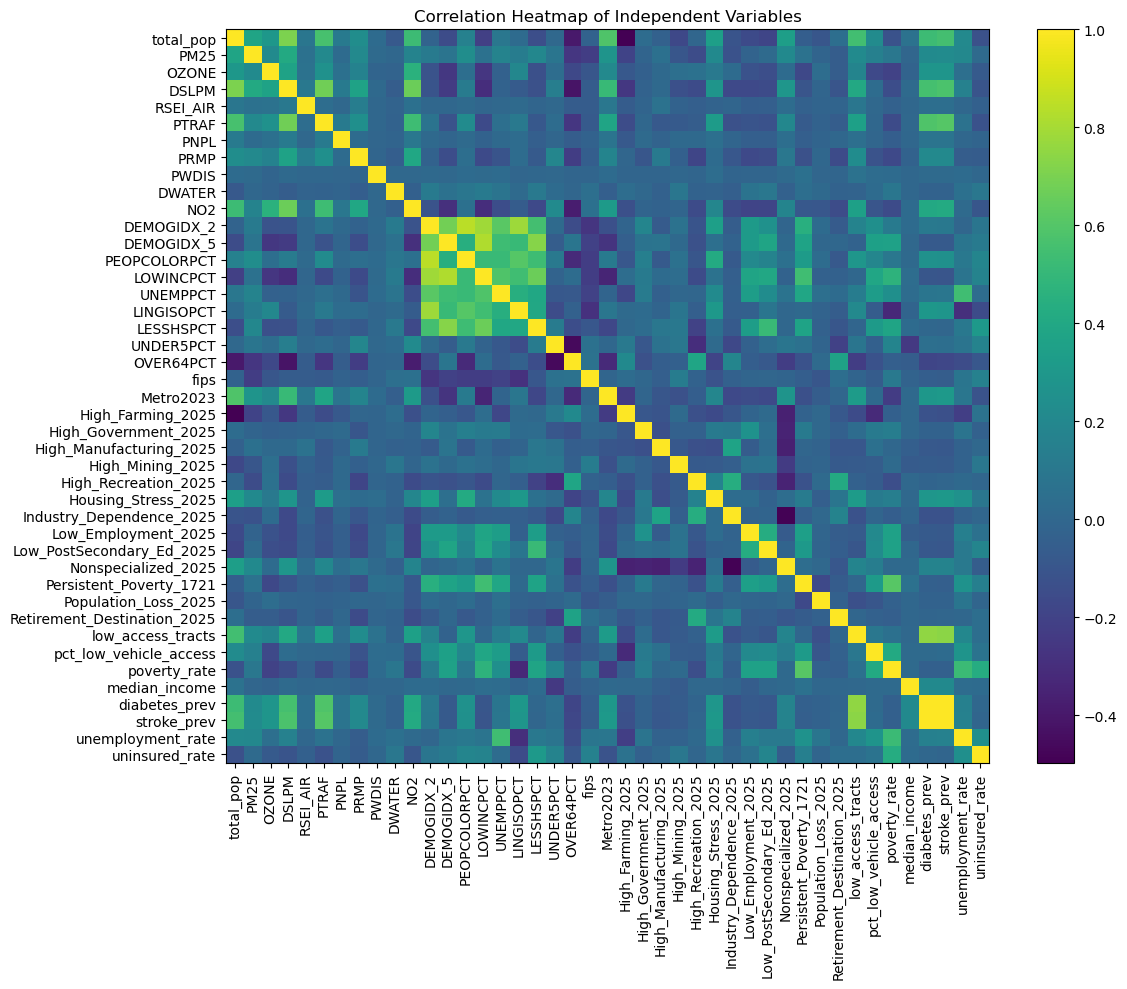

In [56]:
# Load merged dataset
df = data_cleaned.copy()

# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=[np.number])


numeric_df["poverty_rate"] = numeric_df["poverty_count"] / numeric_df["total_pop"]
numeric_df["unemployment_rate"] = numeric_df["unemployed_count"] / numeric_df["total_pop"]
numeric_df["uninsured_rate"] = numeric_df["uninsured_count"] / numeric_df["total_pop"]
numeric_df["total_pop"] = np.log1p(df["total_pop"])

# Drop poverty_count, unemployed_count, uninsured_count
numeric_df = numeric_df.drop(columns=["poverty_count", "unemployed_count", "uninsured_count"])

# Compute correlation matrix
corr = numeric_df.corr()

# Plot heatmap (matplotlib only, no specified colors)
plt.figure(figsize=(12, 10))
plt.imshow(corr, aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Correlation Heatmap of Independent Variables")

plt.tight_layout()
plt.show()

In [57]:
# Targets
targets = ["diabetes_prev", "stroke_prev"]

ranked_results = {}

for target in targets:
    if target in corr.columns:
        ranked = corr[target].drop(labels=[target]).abs().sort_values(ascending=False)
        ranked_results[target] = ranked

# Extract top 20 predictors for diabetes_prev
top_diabetes = ranked_results["diabetes_prev"].head(20)
top_diabetes

stroke_prev                 0.994584
low_access_tracts           0.752232
PTRAF                       0.586347
DSLPM                       0.557147
total_pop                   0.530519
NO2                         0.405743
Metro2023                   0.296897
LINGISOPCT                  0.294815
Housing_Stress_2025         0.290966
OZONE                       0.283500
PEOPCOLORPCT                0.259983
PM25                        0.221053
median_income               0.210882
PRMP                        0.209355
OVER64PCT                   0.183075
Nonspecialized_2025         0.169826
unemployment_rate           0.153201
High_Farming_2025           0.120520
Industry_Dependence_2025    0.117146
DEMOGIDX_2                  0.108128
Name: diabetes_prev, dtype: float64

In [58]:
# Extract top 20 predictors for stroke_prev
top_stroke = ranked_results["stroke_prev"].head(20)
top_stroke

diabetes_prev               0.994584
low_access_tracts           0.737570
PTRAF                       0.604597
DSLPM                       0.577473
total_pop                   0.554268
NO2                         0.415541
Metro2023                   0.310801
Housing_Stress_2025         0.303543
LINGISOPCT                  0.286679
OZONE                       0.285590
PEOPCOLORPCT                0.257388
PM25                        0.223269
median_income               0.213146
PRMP                        0.207583
OVER64PCT                   0.178539
Nonspecialized_2025         0.173761
unemployment_rate           0.163062
High_Farming_2025           0.129321
Industry_Dependence_2025    0.117552
DEMOGIDX_2                  0.105260
Name: stroke_prev, dtype: float64

In [99]:
# Load merged dataset
df = data_cleaned.copy()

# Columns that represent raw counts
count_cols = [
    "poverty_count", "unemployed_count", "uninsured_count",
    "stroke_prev", "diabetes_prev", 'High_Manufacturing_2025', 'Low_Employment_2025', 'Low_Postsecondary_Ed_2025',
]

# Check existence
existing = [c for c in count_cols if c in df.columns]

# Create log-transformed population
if "total_pop" in df.columns:
    df["log_total_pop"] = np.log1p(df["total_pop"])
else:
    raise ValueError("total_pop column missing.")

# Create rates per 100k
for col in existing:
    df[col + "_rate"] = df[col] / df["total_pop"] * 100000

# Drop raw count columns safely
df_clean = df.drop(columns=existing)

# Save cleaned file
output_path = "/Users/sankates/workspace/MSAI/AI-391MCSML/data_normalized_for_modeling.csv"
df_clean.to_csv(output_path, index=False)


In [100]:
df_clean.head()

,total_pop,PM25,OZONE,DSLPM,RSEI_AIR,PTRAF,PNPL,PRMP,PWDIS,DWATER,...,poverty_rate,median_income,log_total_pop,poverty_count_rate,unemployed_count_rate,uninsured_count_rate,stroke_prev_rate,diabetes_prev_rate,High_Manufacturing_2025_rate,Low_Employment_2025_rate
0,3407.0,NaN,NaN,NaN,18.795745,0.000000e+00,0.000000,2.357087,NaN,10.247465,...,NaN,79961,8.133881,12591.722923,3111.241561,5077.781039,102.729674,355.151159,29.351335,0.000000
1,5219.0,NaN,NaN,NaN,3.631383,0.000000e+00,0.323449,0.188127,NaN,3.983852,...,NaN,100662,8.560253,9158.842690,2107.683464,2739.988504,120.712780,392.795555,19.160759,0.000000
2,290674.0,NaN,NaN,NaN,47.484369,1.186345e+06,1.337817,0.447789,NaN,2.031263,...,NaN,95731,12.579961,9431.528104,2665.185053,809.841954,61.133779,177.587263,0.000000,0.000000
3,18538.0,NaN,NaN,NaN,24.384799,0.000000e+00,0.000000,0.000000,NaN,26.544131,...,NaN,64094,9.827632,24738.375229,6823.821340,1558.959974,87.927500,206.602654,0.000000,5.394325
4,854.0,NaN,NaN,NaN,22.729112,0.000000e+00,0.000000,0.192515,NaN,23.652174,...,NaN,94167,6.751101,7728.337237,1405.152225,585.480094,456.674473,1252.927400,117.096019,0.000000


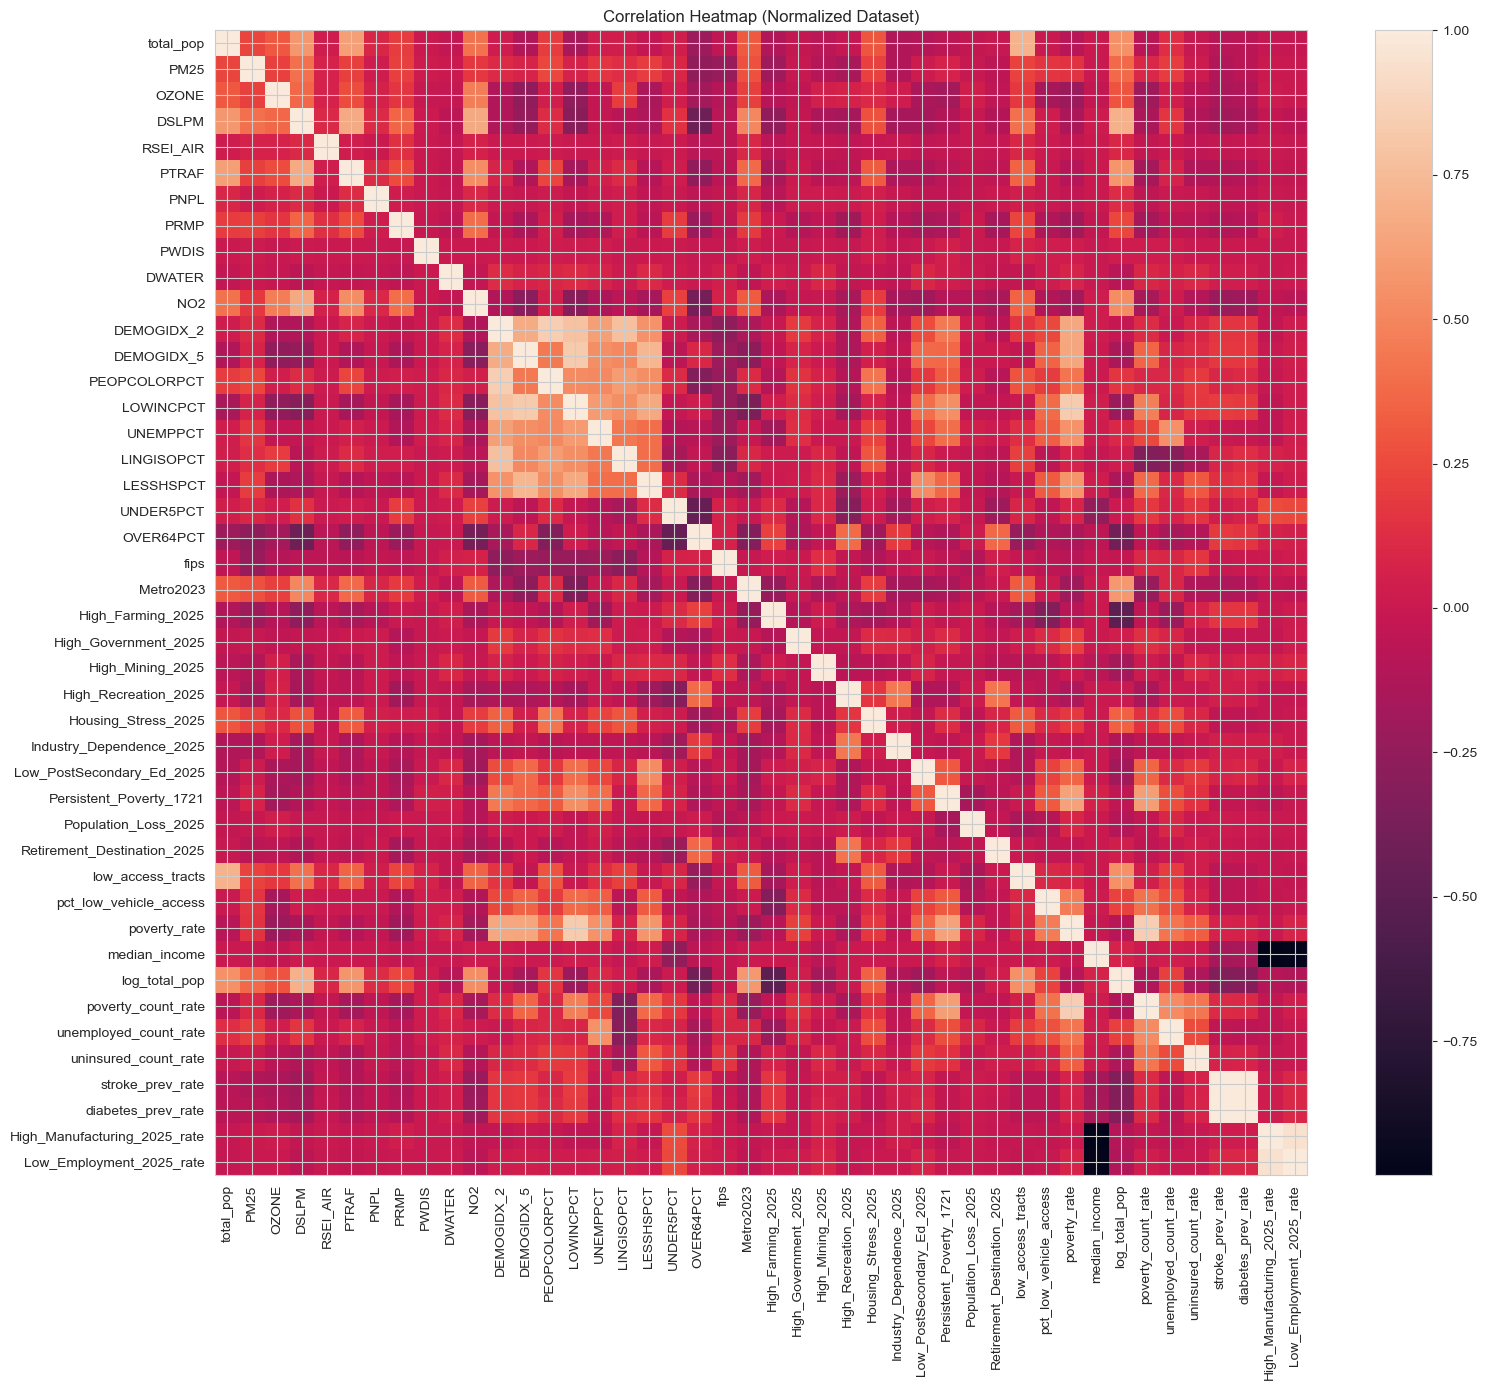

In [101]:
# Create heatmap of correlations in normalized dataset

# Select numeric columns only
numeric_df = df_clean.select_dtypes(include=[np.number])

# Drop specified column
if 'Nonspecialized_2025' in numeric_df.columns:
    numeric_df = numeric_df.drop(columns=['Nonspecialized_2025'])

# Compute correlation matrix
corr = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(16, 14))
plt.imshow(corr, aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Correlation Heatmap (Normalized Dataset)")
plt.tight_layout()
plt.show()

In [126]:
# Modeling script

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score


# ---------------------------------------------------
# 0. Load your merged dataset
# ---------------------------------------------------
df = df_clean.copy()

# targets (dependent variables)
y_diab = df["diabetes_prev_rate"]
y_stroke = df["stroke_prev_rate"]

# drop rows where either target is missing
mask = y_diab.notna() & y_stroke.notna()
df = df[mask].copy()
y_diab = y_diab[mask]
y_stroke = y_stroke[mask]



# Winsorize (cap at 99th percentile) as a quick fix
from scipy.stats import mstats
y_diab_winsor = mstats.winsorize(y_diab, limits=[0, 0.05])  # Cap top 1%
y_stroke_winsor = mstats.winsorize(y_stroke, limits=[0, 0.05])

# ---------------------------------------------------
# 2. Define feature matrix X
# ---------------------------------------------------
drop_cols = set(["diabetes_prev_rate",
                              "stroke_prev_rate", "total_pop", "log_total_pop",
                              "fips"])  # fips is an ID, not a feature

numeric_cols = df.select_dtypes(include=[np.number]).columns
feature_cols = [c for c in numeric_cols if c not in drop_cols]

X = df[feature_cols]

# simple mean imputation for any remaining NaNs
X = X.fillna(X.mean())

# ---------------------------------------------------
# 3. Train–test split (shared for both targets)
# ---------------------------------------------------
X_train, X_test, yD_train, yD_test, yS_train, yS_test = train_test_split(
    X, y_diab_winsor, y_stroke_winsor, test_size=0.2, random_state=42
)

# ---------------------------------------------------
# 4. Helper to train + evaluate a model
# ---------------------------------------------------
def eval_model(model, X_tr, X_te, y_tr, y_te):
    model.fit(X_tr, y_tr)
    preds = model.predict(X_te)
    rmse = np.sqrt(mean_squared_error(y_te, preds))
    r2 = r2_score(y_te, preds)
    return rmse, r2

results = []

# ---------------------------------------------------
# 5. MODELS
# ---------------------------------------------------

# 5.1 Linear Regression (needs scaling)
lin_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("linreg", LinearRegression())
])

results.append(["LinearRegression", "diabetes"] +
               list(eval_model(lin_pipeline, X_train, X_test, yD_train, yD_test)))
results.append(["LinearRegression", "stroke"] +
               list(eval_model(lin_pipeline, X_train, X_test, yS_train, yS_test)))

# 5.2 Random Forest (nonlinear, handles interactions)
rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

results.append(["RandomForest", "diabetes"] +
               list(eval_model(rf, X_train, X_test, yD_train, yD_test)))
results.append(["RandomForest", "stroke"] +
               list(eval_model(rf, X_train, X_test, yS_train, yS_test)))

# 5.3 Gradient Boosting (you can swap in XGBoost if installed)
#gb = GradientBoostingRegressor(random_state=42)
gb = XGBRegressor(n_estimators=300, learning_rate=0.05, random_state=42, n_jobs=-1)


results.append(["XGBoost", "diabetes"] +
               list(eval_model(gb, X_train, X_test, yD_train, yD_test)))
results.append(["XGBoost", "stroke"] +
               list(eval_model(gb, X_train, X_test, yS_train, yS_test)))

# 5.4 Elastic Net (L1 + L2 regularized linear model)
en_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("enet", ElasticNet(alpha=0.1, l1_ratio=0.5,
                        random_state=42, max_iter=10000))
])

results.append(["ElasticNet", "diabetes"] +
               list(eval_model(en_pipeline, X_train, X_test, yD_train, yD_test)))
results.append(["ElasticNet", "stroke"] +
               list(eval_model(en_pipeline, X_train, X_test, yS_train, yS_test)))

# ---------------------------------------------------
# 6. Compare performance
# ---------------------------------------------------
results_df = pd.DataFrame(results,
                          columns=["Model", "Target", "RMSE", "R2"])

print(results_df.sort_values(["Target", "R2"], ascending=[True, False]))


              Model    Target        RMSE        R2
2      RandomForest  diabetes   97.033926  0.655837
4           XGBoost  diabetes   97.090497  0.655435
6        ElasticNet  diabetes  103.114787  0.611349
0  LinearRegression  diabetes  103.861457  0.605700
5           XGBoost    stroke   30.310563  0.704462
3      RandomForest    stroke   30.932333  0.692212
1  LinearRegression    stroke   32.652272  0.657033
7        ElasticNet    stroke   32.722188  0.655563


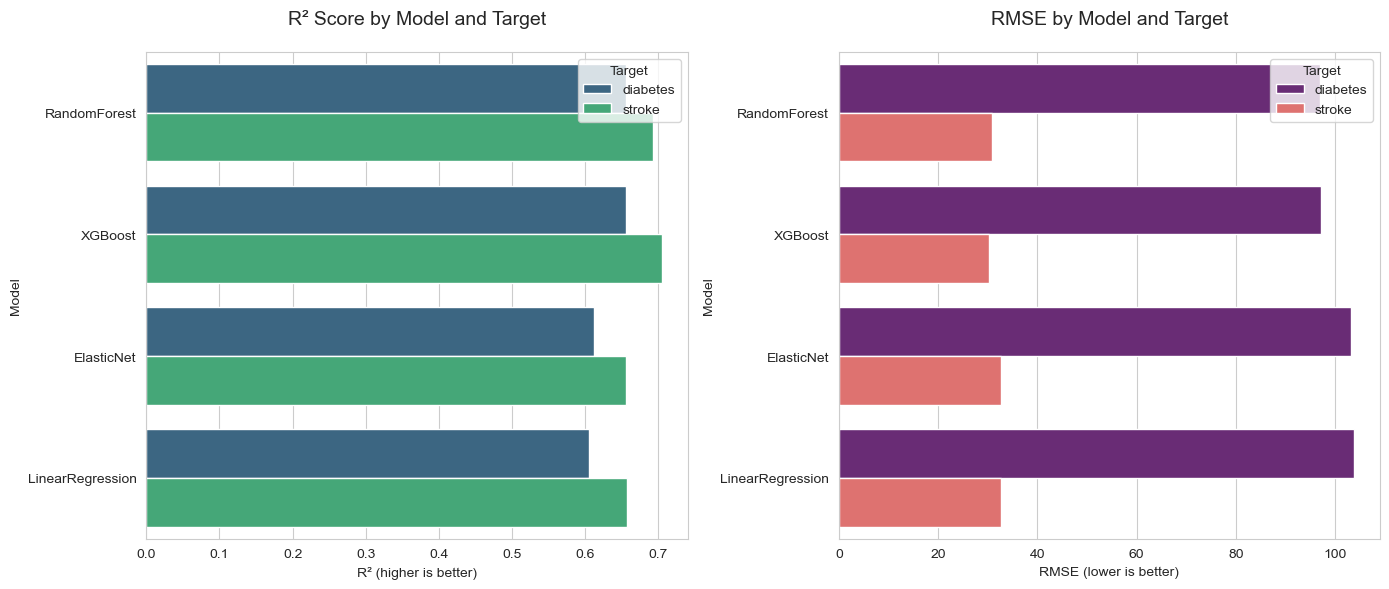

In [127]:
# Plotting model performance

# Make sure results_df exists 
results_df = pd.DataFrame(results, columns=["Model", "Target", "RMSE", "R2"])
results_df = results_df.sort_values(["Target", "R2"], ascending=[True, False])

# Set style
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

# R² plot
sns.barplot(data=results_df, x="R2", y="Model", hue="Target", ax=axes[0], palette="viridis")
axes[0].set_title("R² Score by Model and Target", fontsize=14, pad=20)
axes[0].set_xlabel("R² (higher is better)")
axes[0].legend(title="Target")

# RMSE plot
sns.barplot(data=results_df, x="RMSE", y="Model", hue="Target", ax=axes[1], palette="magma")
axes[1].set_title("RMSE by Model and Target", fontsize=14, pad=20)
axes[1].set_xlabel("RMSE (lower is better)")
axes[1].legend(title="Target")

plt.tight_layout()
plt.show()

# Hyperparameter tuning for the top 2 models

In [128]:
# Random Forest hyperparameters
rf_param_dist = {
    "n_estimators": [100, 200, 400],
    "max_depth": [10, 15, 20, None],
    "max_features": ["sqrt", "log2", 0.3, 0.5, 0.7],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False],
}

# XGBoost Boosting hyperparameters
xgb_param_dist = {
    "n_estimators": [200, 400, 600, 1000],  # Higher for early stopping
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "max_depth": [2, 3, 4, 5],
    "min_child_weight": [1, 3, 5],  # Replace min_samples_leaf
    "gamma": [0, 0.1, 0.2],  # For split regularization (like min_samples_split)
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],  # Add this
}


from sklearn.model_selection import RandomizedSearchCV

def tune_and_eval(name, estimator, param_dist, X_train, y_train, X_test, y_test,
                  n_iter=25):
    search = RandomizedSearchCV(
        estimator,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring="r2",
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=1,
    )
    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    preds = best_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    return {
        "name": name,
        "best_params": search.best_params_,
        "rmse": rmse,
        "r2": r2,
        "model": best_model,
    }

# Example: Tune Random Forest for diabetes_prev_rate
results = []

# ---- Diabetes models ----
rf_diab = tune_and_eval(
    "RandomForest_diabetes",
    RandomForestRegressor(random_state=42),
    rf_param_dist,
    X_train, yD_train, X_test, yD_test,
    n_iter=25
)
results.append(rf_diab)

gb_diab = tune_and_eval(
    "XGBoost_diabetes",
    XGBRegressor(random_state=42),
    xgb_param_dist,
    X_train, yD_train, X_test, yD_test,
    n_iter=25
)
results.append(gb_diab)

# ---- Stroke models ----
rf_stroke = tune_and_eval(
    "RandomForest_stroke",
    RandomForestRegressor(random_state=42),
    rf_param_dist,
    X_train, yS_train, X_test, yS_test,
    n_iter=25
)
results.append(rf_stroke)

gb_stroke = tune_and_eval(
    "XGBoost_stroke",
    XGBRegressor(random_state=42),
    xgb_param_dist,
    X_train, yS_train, X_test, yS_test,
    n_iter=25
)
results.append(gb_stroke)

# Display tuning results
for res in results:
    print(f"Model: {res['name']}")
    print("Best Parameters:")
    for param, value in res['best_params'].items():
        print(f"  - {param}: {value}")
    print(f"R²: {res['r2']:.4f}, RMSE: {res['rmse']:.4f}")
    print("-" * 40)


Fitting 3 folds for each of 25 candidates, totalling 75 fits
Fitting 3 folds for each of 25 candidates, totalling 75 fits
Fitting 3 folds for each of 25 candidates, totalling 75 fits
Fitting 3 folds for each of 25 candidates, totalling 75 fits
Model: RandomForest_diabetes
Best Parameters:
  - n_estimators: 400
  - min_samples_split: 2
  - min_samples_leaf: 1
  - max_features: 0.3
  - max_depth: 15
  - bootstrap: False
R²: 0.6646, RMSE: 95.7949
----------------------------------------
Model: XGBoost_diabetes
Best Parameters:
  - subsample: 0.6
  - n_estimators: 1000
  - min_child_weight: 3
  - max_depth: 5
  - learning_rate: 0.01
  - gamma: 0.1
  - colsample_bytree: 0.8
R²: 0.6800, RMSE: 93.5707
----------------------------------------
Model: RandomForest_stroke
Best Parameters:
  - n_estimators: 400
  - min_samples_split: 2
  - min_samples_leaf: 1
  - max_features: 0.3
  - max_depth: 15
  - bootstrap: False
R²: 0.7036, RMSE: 30.3569
----------------------------------------
Model: XGBoo

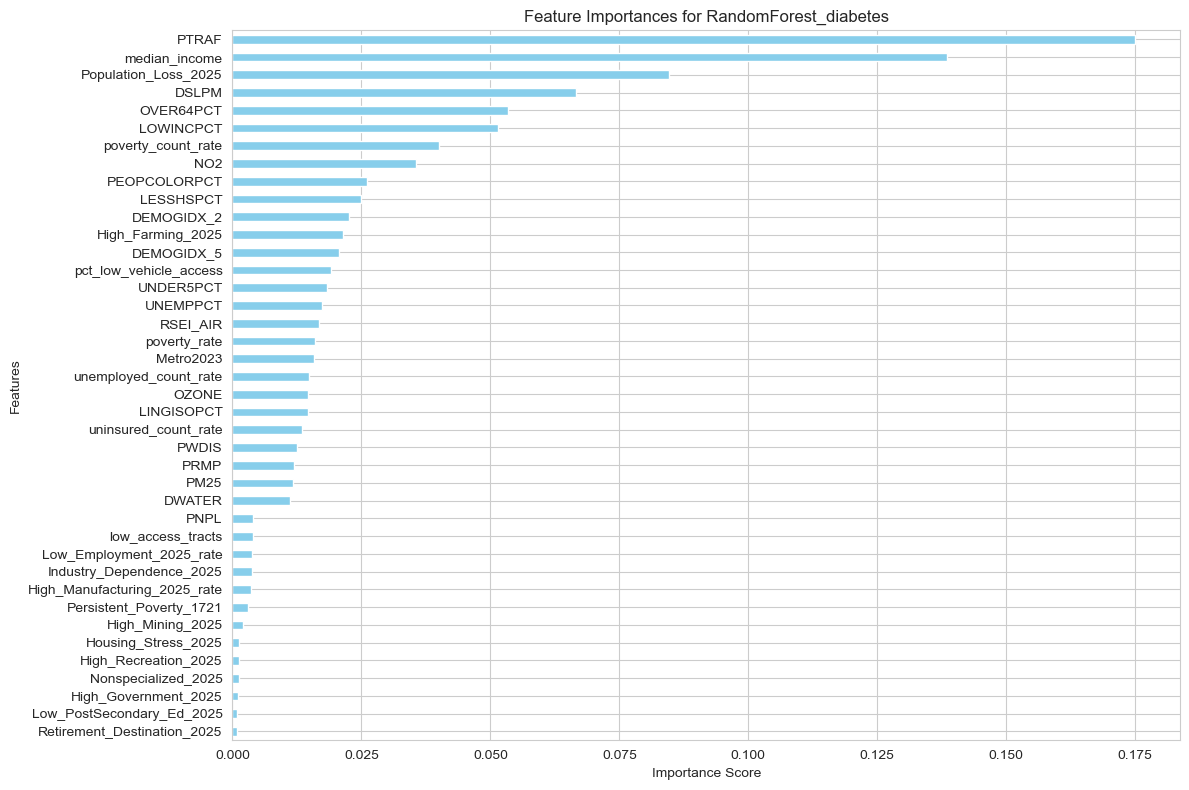

Top 10 Features for RandomForest_diabetes:
PTRAF                   0.174937
median_income           0.138520
Population_Loss_2025    0.084540
DSLPM                   0.066507
OVER64PCT               0.053423
LOWINCPCT               0.051559
poverty_count_rate      0.040006
NO2                     0.035530
PEOPCOLORPCT            0.026061
LESSHSPCT               0.024879
dtype: float64

--------------------------------------------------



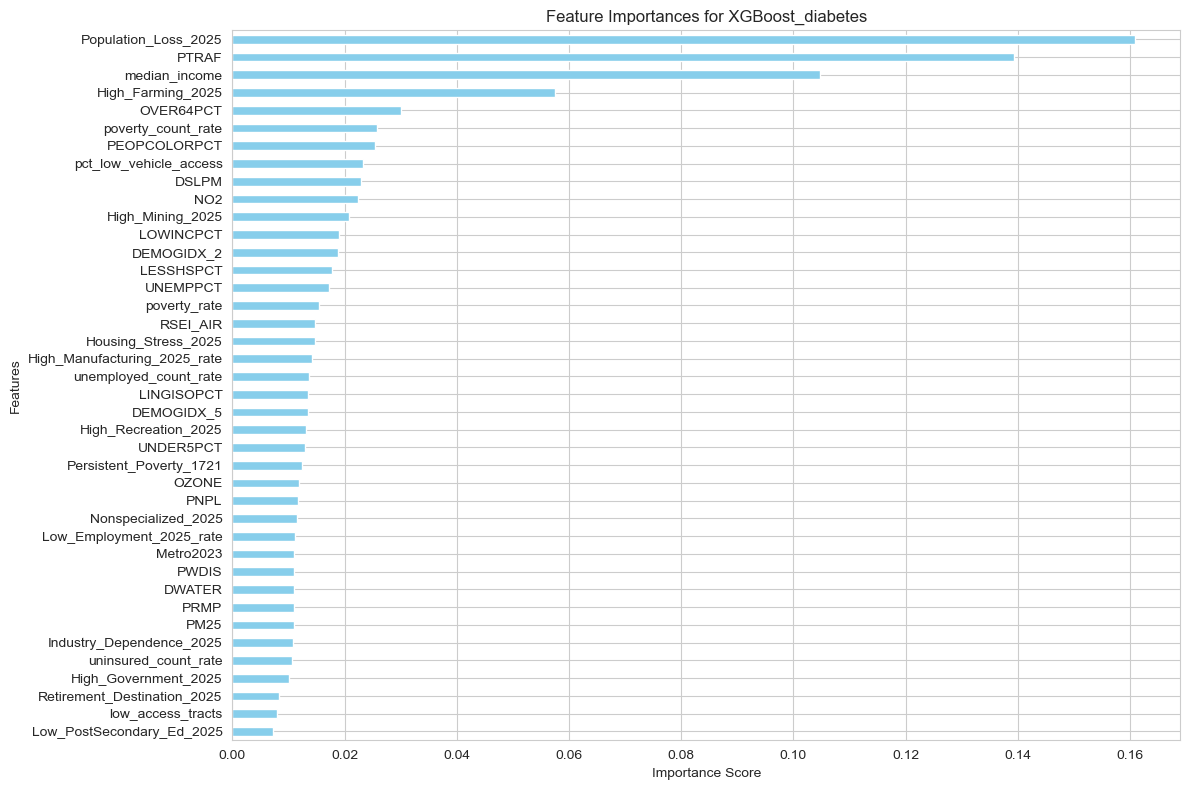

Top 10 Features for XGBoost_diabetes:
Population_Loss_2025      0.160859
PTRAF                     0.139243
median_income             0.104816
High_Farming_2025         0.057504
OVER64PCT                 0.030062
poverty_count_rate        0.025773
PEOPCOLORPCT              0.025360
pct_low_vehicle_access    0.023241
DSLPM                     0.022884
NO2                       0.022475
dtype: float32

--------------------------------------------------



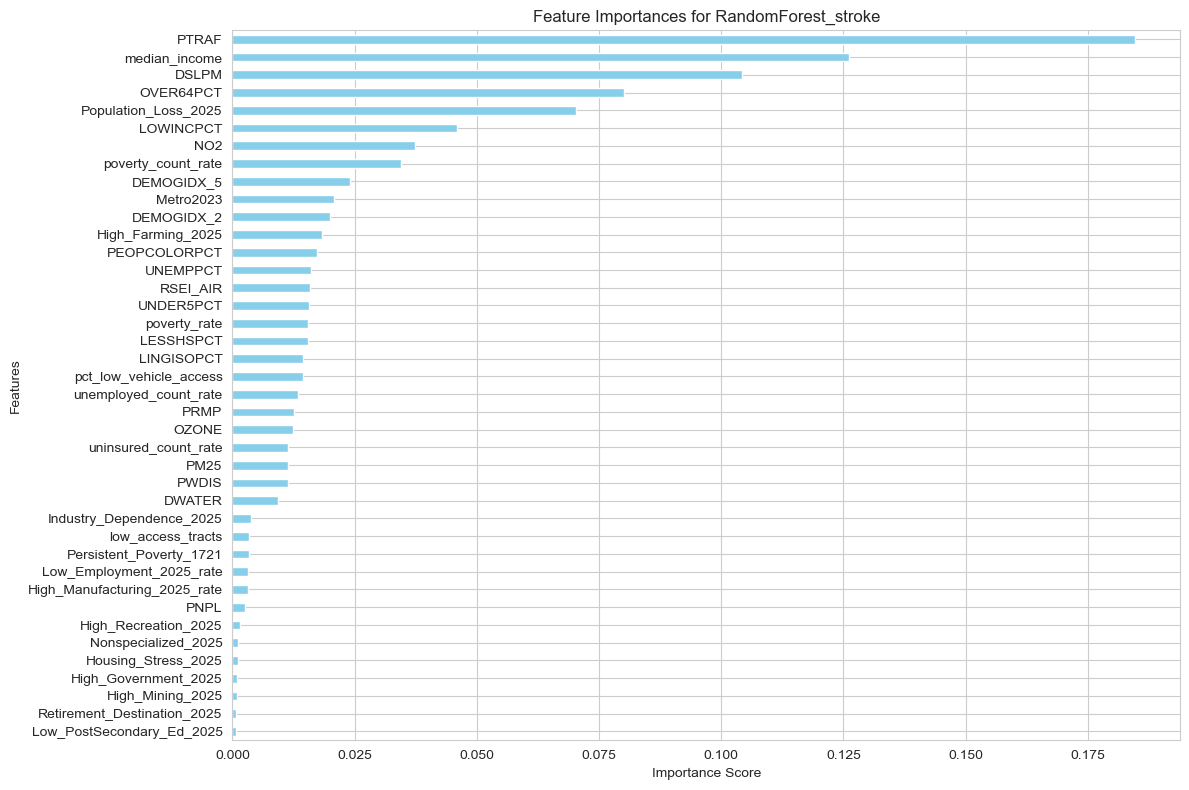

Top 10 Features for RandomForest_stroke:
PTRAF                   0.184603
median_income           0.126162
DSLPM                   0.104185
OVER64PCT               0.080139
Population_Loss_2025    0.070341
LOWINCPCT               0.045969
NO2                     0.037371
poverty_count_rate      0.034504
DEMOGIDX_5              0.023977
Metro2023               0.020745
dtype: float64

--------------------------------------------------



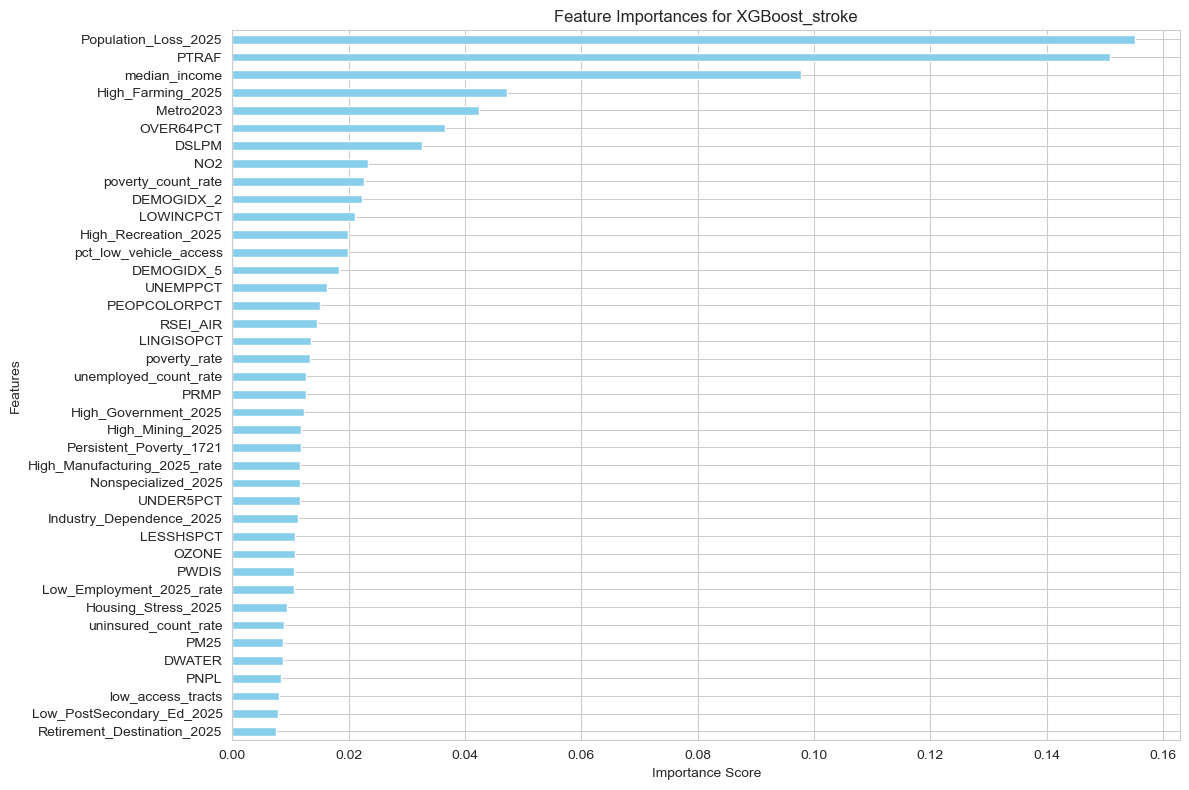

Top 10 Features for XGBoost_stroke:
Population_Loss_2025    0.155176
PTRAF                   0.150960
median_income           0.097816
High_Farming_2025       0.047284
Metro2023               0.042388
OVER64PCT               0.036477
DSLPM                   0.032674
NO2                     0.023365
poverty_count_rate      0.022645
DEMOGIDX_2              0.022352
dtype: float32

--------------------------------------------------



In [129]:
# Plot feature importances for the best models

for res in results:
    best_model = res['model']
    model_name = res['name']
    
    # Get feature importances as a sorted Series
    importances = pd.Series(
        best_model.feature_importances_, 
        index=X.columns
    ).sort_values(ascending=False)  # Sort descending for top features first
    
    # Plot
    plt.figure(figsize=(12, 8))  # Adjust size for readability
    importances.plot(kind='barh', color='skyblue')
    plt.title(f"Feature Importances for {model_name}")
    plt.xlabel("Importance Score")
    plt.ylabel("Features")
    plt.gca().invert_yaxis()  # Highest importance at the top
    plt.tight_layout()
    plt.show()
    
    # Optional: Print top 10 for quick view
    print(f"Top 10 Features for {model_name}:")
    print(importances.head(10))
    print("\n" + "-" * 50 + "\n")

In [130]:
# Summarize tuning results

summary = pd.DataFrame([
    {
        "Model": r["name"],
        "Target": "diabetes" if "diabetes" in r["name"] else "stroke",
        "RMSE": r["rmse"],
        "R2": r["r2"]
    }
    for r in results
])

print(summary.sort_values(["Target", "R2"], ascending=[True, False]))


                   Model    Target       RMSE        R2
1       XGBoost_diabetes  diabetes  93.570742  0.679965
0  RandomForest_diabetes  diabetes  95.794908  0.664570
3         XGBoost_stroke    stroke  29.629978  0.717585
2    RandomForest_stroke    stroke  30.356879  0.703558


In [131]:
from sklearn.ensemble import VotingRegressor

# Diabetes example (repeat for stroke with yS)
ensemble_diab = VotingRegressor(estimators=[
    ('xgb', results[1]['model']),  # Assuming results list order from your output
    ('rf', results[0]['model'])
])
ensemble_diab.fit(X_train, yD_train)  # Or full X/y for final model
preds_ens = ensemble_diab.predict(X_test)
rmse_ens = root_mean_squared_error(yD_test, preds_ens)
r2_ens = r2_score(yD_test, preds_ens)
print(f"Ensemble Diabetes: RMSE={rmse_ens:.2f}, R²={r2_ens:.4f}")

Ensemble Diabetes: RMSE=93.76, R²=0.6787


/var/folders/xv/jppz3tnj7z10dvcn0jp_xfk00000gp/T/ipykernel_60556/3870510824.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_data, plot_type="dot", show=False)


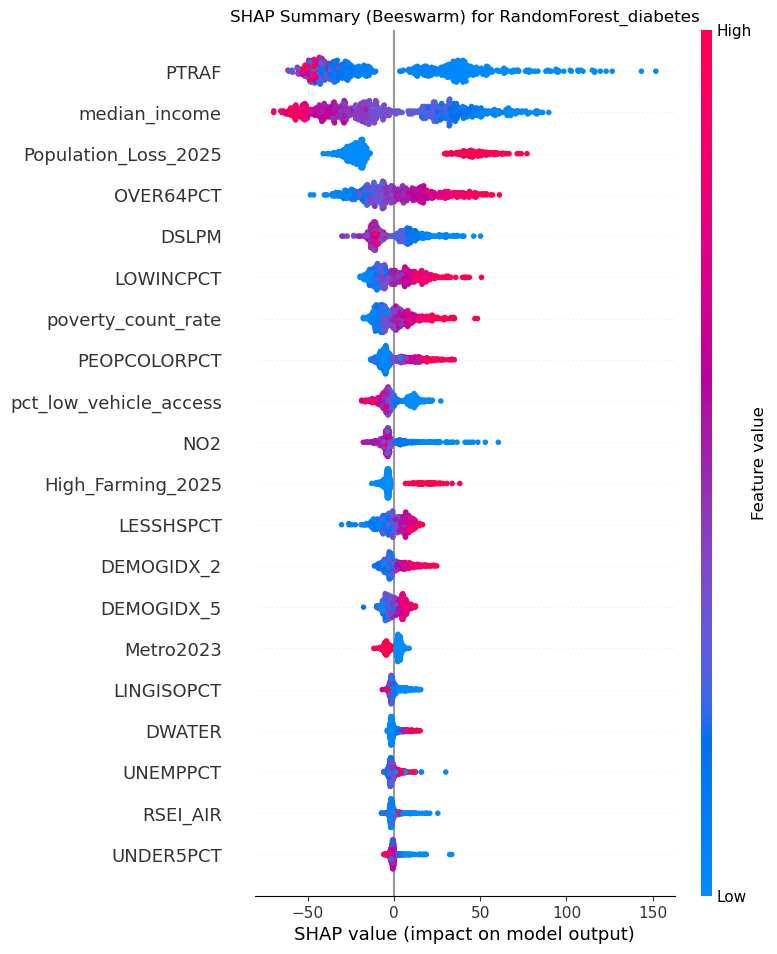

/var/folders/xv/jppz3tnj7z10dvcn0jp_xfk00000gp/T/ipykernel_60556/3870510824.py:20: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_data, plot_type="bar", show=False)


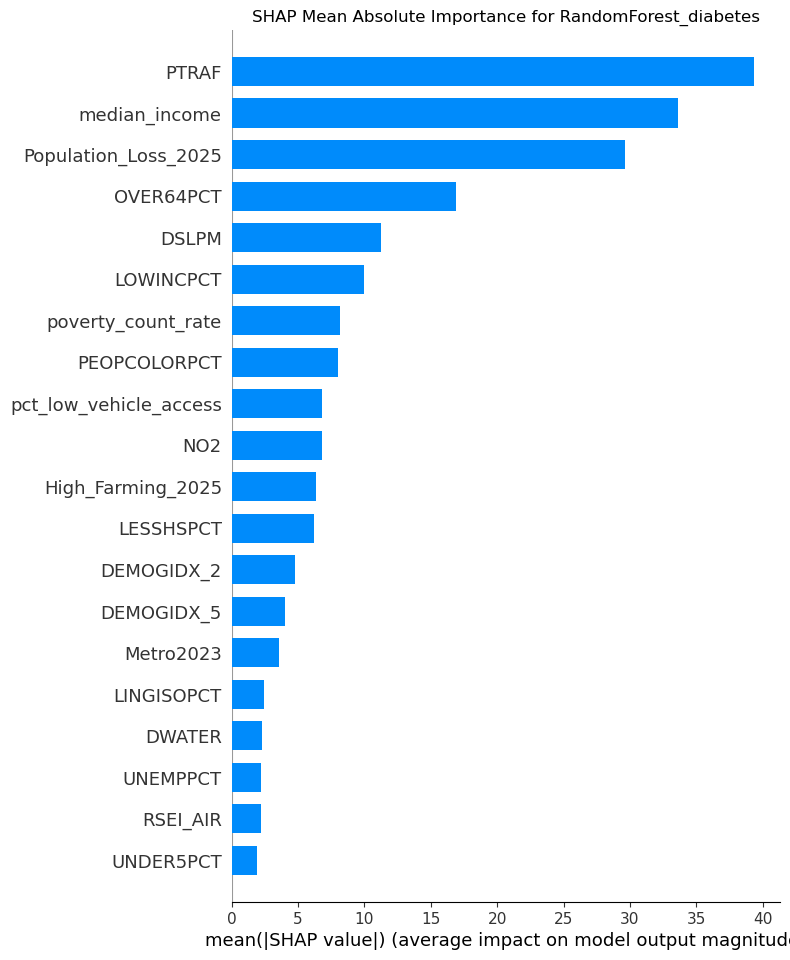

/var/folders/xv/jppz3tnj7z10dvcn0jp_xfk00000gp/T/ipykernel_60556/3870510824.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_data, plot_type="dot", show=False)


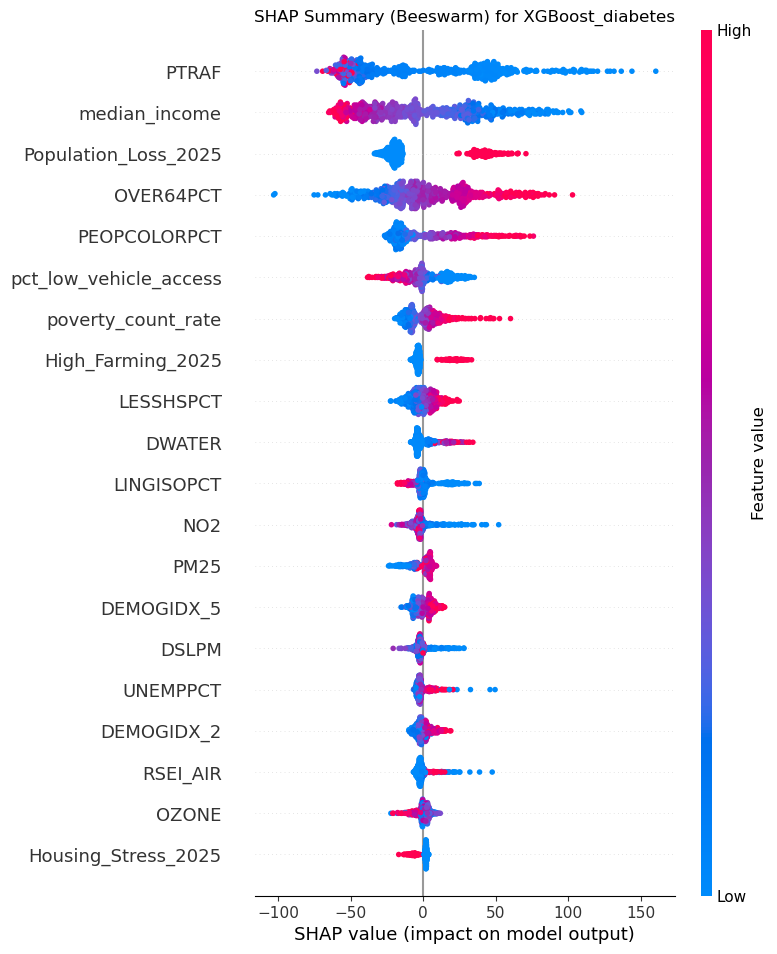

/var/folders/xv/jppz3tnj7z10dvcn0jp_xfk00000gp/T/ipykernel_60556/3870510824.py:20: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_data, plot_type="bar", show=False)


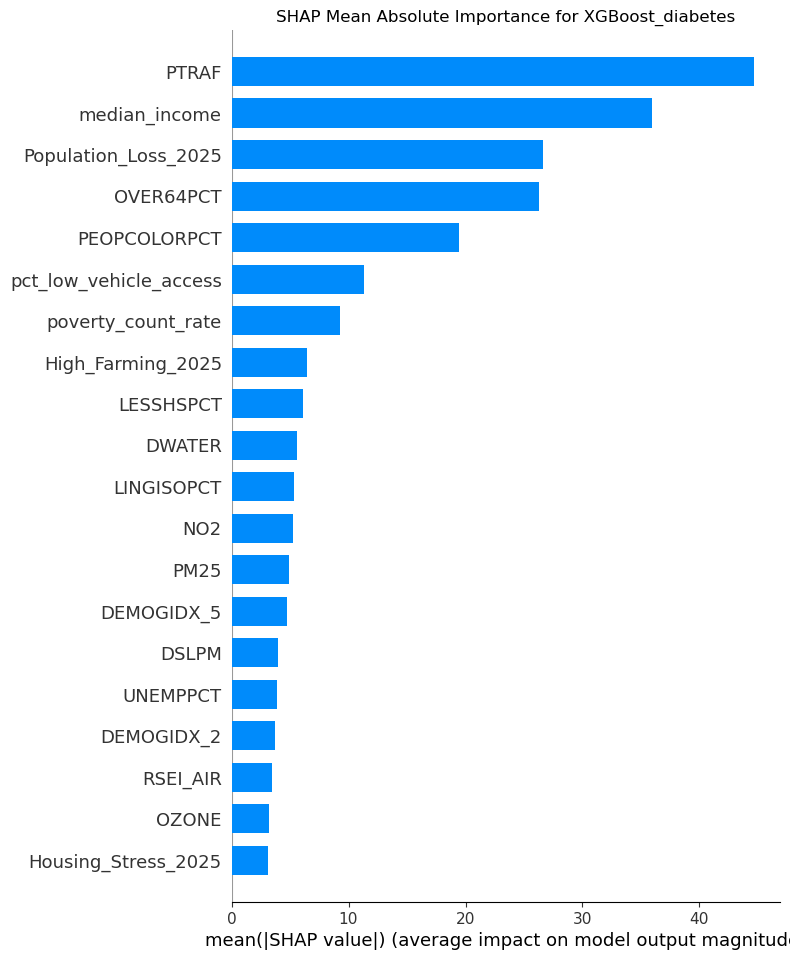

/var/folders/xv/jppz3tnj7z10dvcn0jp_xfk00000gp/T/ipykernel_60556/3870510824.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_data, plot_type="dot", show=False)


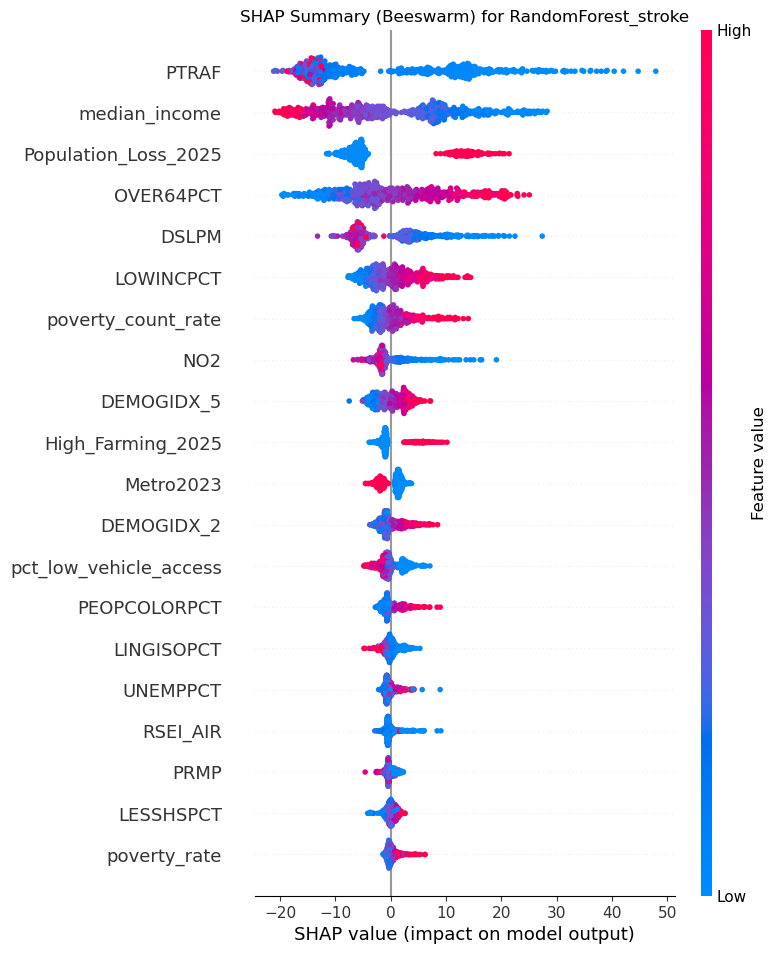

/var/folders/xv/jppz3tnj7z10dvcn0jp_xfk00000gp/T/ipykernel_60556/3870510824.py:20: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_data, plot_type="bar", show=False)


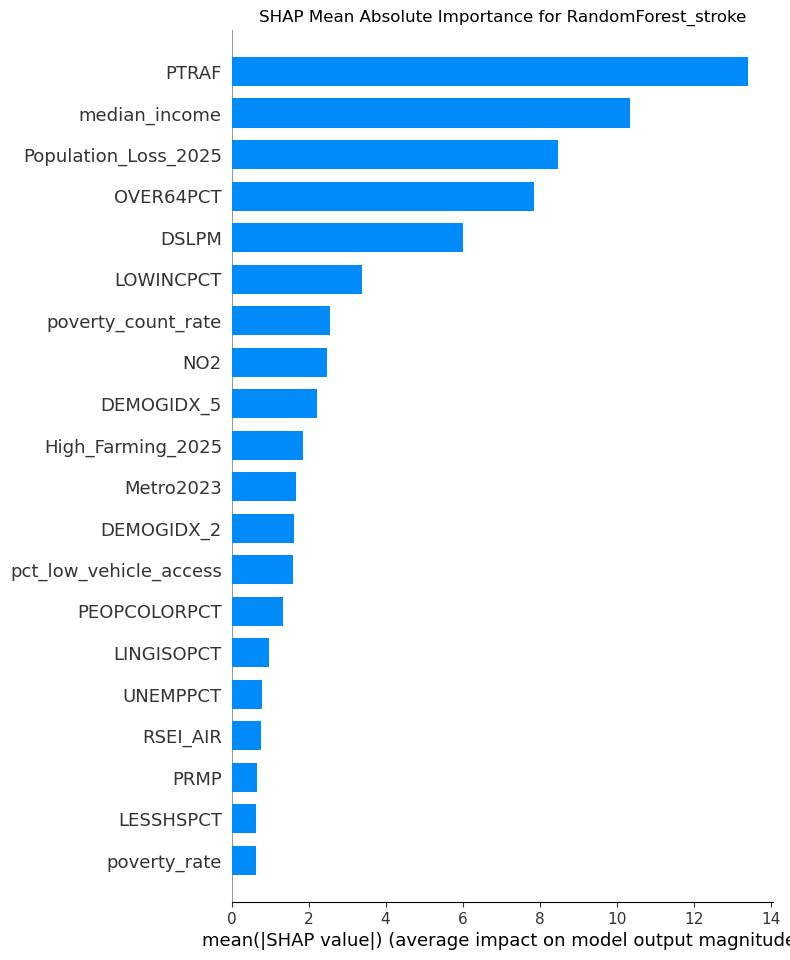

/var/folders/xv/jppz3tnj7z10dvcn0jp_xfk00000gp/T/ipykernel_60556/3870510824.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_data, plot_type="dot", show=False)


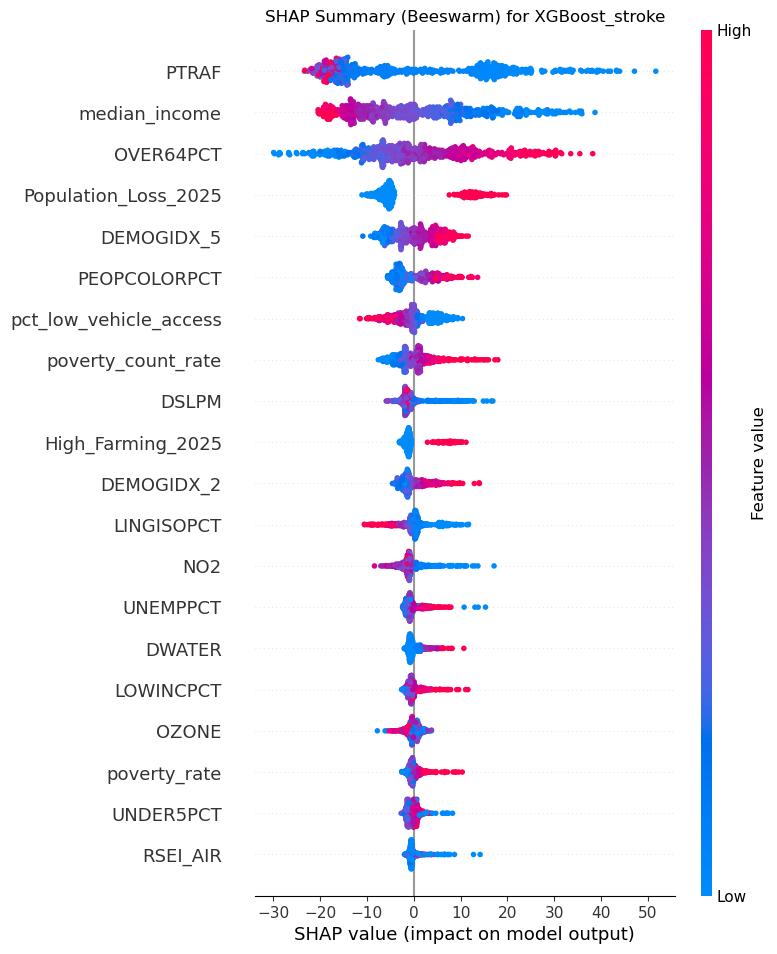

/var/folders/xv/jppz3tnj7z10dvcn0jp_xfk00000gp/T/ipykernel_60556/3870510824.py:20: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_data, plot_type="bar", show=False)


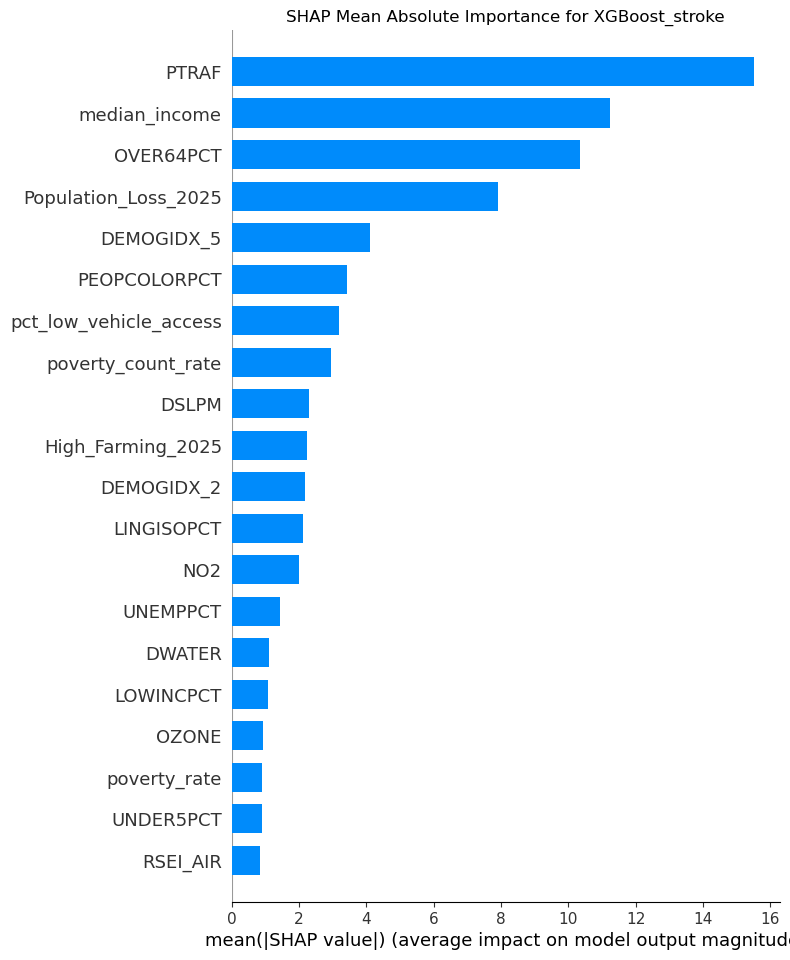

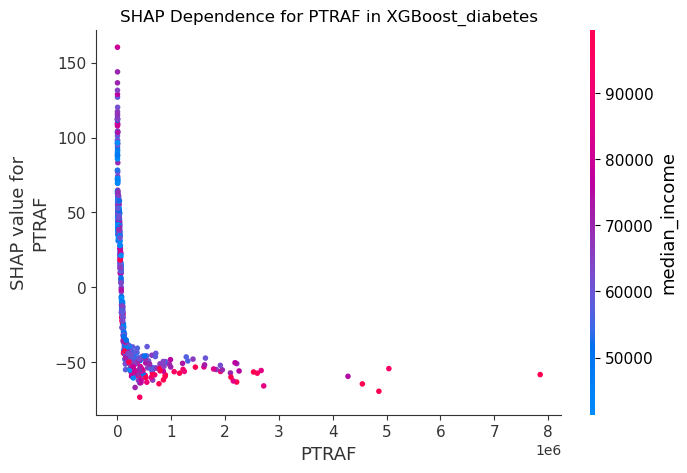

In [138]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Function to compute and plot SHAP for a model
def shap_analysis(model, model_name, X_data, top_features_only=False):
    # Use TreeExplainer for efficiency on tree models (RF or XGB)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_data)
    
    # Summary plot: Shows global feature importance with direction (beeswarm)
    plt.figure()
    shap.summary_plot(shap_values, X_data, plot_type="dot", show=False)
    plt.title(f"SHAP Summary (Beeswarm) for {model_name}")
    plt.show()
    
    # Bar plot: Mean absolute SHAP values (global importance with magnitude)
    plt.figure()
    shap.summary_plot(shap_values, X_data, plot_type="bar", show=False)
    plt.title(f"SHAP Mean Absolute Importance for {model_name}")
    plt.show()
    
    # If top_features_only=True, filter to top 10 from your lists
    if top_features_only:
        # Example: Limit to top 10 features (replace with your actual top lists)
        top_indices = np.argsort(-np.abs(shap_values).mean(0))[:10]
        shap_values_top = shap_values[:, top_indices]
        X_top = X_data.iloc[:, top_indices] if isinstance(X_data, pd.DataFrame) else X_data[:, top_indices]
        shap.summary_plot(shap_values_top, X_top, show=False)
        plt.title(f"SHAP for Top 10 Features in {model_name}")
        plt.show()
    
    # Return SHAP values for further analysis (e.g., per county)
    return shap_values, explainer.expected_value  # Base value for predictions

# Run for each model (use X_test or a random subset for speed; e.g., X_test.sample(500))
# Ensure X_test has column names for better plots
X_shap = X_test.copy()  # Or X for global view, but test set is better for unbiased explainability

# Diabetes models
rf_diab_shap, rf_diab_base = shap_analysis(results[0]['model'], "RandomForest_diabetes", X_shap)
xgb_diab_shap, xgb_diab_base = shap_analysis(results[1]['model'], "XGBoost_diabetes", X_shap)

# Stroke models
rf_stroke_shap, rf_stroke_base = shap_analysis(results[2]['model'], "RandomForest_stroke", X_shap)
xgb_stroke_shap, xgb_stroke_base = shap_analysis(results[3]['model'], "XGBoost_stroke", X_shap)

# Example: Dependence plot for a key feature (e.g., PTRAF's impact)
shap.dependence_plot("PTRAF", xgb_diab_shap, X_shap, show=False)  # Shows how PTRAF interacts with others
plt.title("SHAP Dependence for PTRAF in XGBoost_diabetes")
plt.show()

# Set matplotlib style to a white background theme (e.g., 'default' or 'classic')
plt.style.use('default')  # 'default' typically gives white background; alternatives: 'classic' or 'seaborn-white'

# Optional: Local explanation for a specific county (row index in X_shap)
# Get index of a county to explain based on FIPS
idx = data.index[data['fips'] == 6037] # Example FIPS for Los Angeles County
instance_idx = idx[0] if len(idx) > 0 else 0 # Use found index or default to 0
shap.initjs() # For interactive force plots
force_plot = shap.force_plot(xgb_diab_base, xgb_diab_shap[instance_idx, :], X_shap.iloc[instance_idx, :], )
display(force_plot) # In Jupyter, this shows an interactive plot